In [1]:
import pandas as pd

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [4]:
APP_NAME = "Survival Analysis EDA"

try:
    sc.stop()
    spark.stop()
except:
    pass

from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

try:
    sc and spark
except (NameError, UnboundLocalError) as e:
    import findspark
    #findspark.init()
    import pyspark
    import pyspark.sql
    
    #sc = pyspark.SparkContext()
    #spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
    
sc = SparkContext(conf = SparkConf() .set("spark.driver.maxResultSize", "60g") .set("spark.sql.execution.arrow.enabled", "true") .set('spark.sql.broadcastTimeout', 1000) .set('spark.local.dir', '/data_data/session_length/spark_tmp/') .set('spark.driver.memory', '60G') .set("spark.executor.instances", "10") .set("spark.executor.cores", 10) .set("spark.executor.memory", "20G")).getOrCreate()
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")
    

In [5]:
sc._conf.getAll()

[(u'spark.local.dir', u'/data_data/session_length/spark_tmp/'),
 (u'spark.driver.maxResultSize', u'60g'),
 (u'spark.sql.execution.arrow.enabled', u'true'),
 (u'spark.executor.id', u'driver'),
 (u'spark.executor.cores', u'10'),
 (u'spark.app.name', u'pyspark-shell'),
 (u'spark.executor.memory', u'20G'),
 (u'spark.app.id', u'local-1541469357372'),
 (u'spark.executor.instances', u'10'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.driver.host', u'ip-172-31-41-62.ec2.internal'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.driver.port', u'41916'),
 (u'spark.master', u'local[*]'),
 (u'spark.driver.memory', u'60G'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.sql.broadcastTimeout', u'1000'),
 (u'spark.ui.showConsoleProgress', u'true')]

In [33]:
from pyspark.sql.types import StructField, StructType, StringType, LongType, DateType, DoubleType, IntegerType, TimestampType
from pyspark.sql.functions import count, mean, stddev_pop, min, max, lit, round, bround, pow, col, corr, lower, upper, avg, stddev, abs, log
from pyspark.sql.functions import lit, trim, rtrim, rpad, trim, coalesce
from pyspark.sql.functions import current_date, current_timestamp, date_add, date_sub, months_between, to_date
from pyspark.sql.functions import udf, col, countDistinct, lag
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, dense_rank, rank, expr

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula, Bucketizer, QuantileDiscretizer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier,NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.linalg import Vectors

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### IMPORT MODEL DATA

In [77]:
!head new_model_1_df_11_06_2018.tsv

userid|session_id|gender|age|country|day_of_week|time_of_day|is_holiday|time_since_epoch|days_since_epoch|absence_time|genre_10_name|genre_9_name|genre_8_name|genre_7_name|genre_6_name|genre_5_name|genre_4_name|genre_3_name|genre_2_name|genre_1_name|undefined_genre_name|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefined_genre_freq|session_length|session_length_1
user_000372|3841|m|Null|Singapore|Saturday|Night|0|149565642|1731|479|trip-hop|punk|classicrock|alternative|indie|chillout|pop|electronic|rock|undefined_genres|undefined_genres|0.01|0.01|0.02|0.02|0.02|0.02|0.02|0.03|0.05|0.27|0.27|4|
user_000372|3840|m|Null|Singapore|Monday|Morning|0|149756668|1733|3156|ambient|folk|metal|femalevocalists|electronic|alternative|pop|indie|rock|undefined_genres|undefined_genres|0.01|0.01|0.01|0.02|0.02|0.02|0.02|0.02|0.06|0.3|0.3|4|4.0
user_000372|3839|m|Null|Singapore|Monday|LateAfternoon|0|149794760|1733|6

#### Define Schema (here we assume 10 genres)

In [115]:
session_Schema = StructType([StructField('userid', StringType(), True), 
                             StructField('session_id', IntegerType(), True), 
                             StructField('gender', StringType(), True), 
                             StructField('age', StringType(), True), 
                             StructField('country', StringType(), True), 
                             StructField('day_of_week', StringType(), True),
                             StructField('time_of_day', StringType(), True), 
                             StructField('is_holiday', IntegerType(), True), 
                             StructField('time_since_epoch', IntegerType(), True), 
                             StructField('days_since_epoch', IntegerType(), True), 
                             StructField('absence_time', IntegerType(), True),
                             StructField('genre_10', StringType(), True),
                             StructField('genre_9', StringType(), True),
                             StructField('genre_8', StringType(), True),
                             StructField('genre_7', StringType(), True),
                             StructField('genre_6', StringType(), True),
                             StructField('genre_5', StringType(), True),
                             StructField('genre_4', StringType(), True),
                             StructField('genre_3', StringType(), True),
                             StructField('genre_2', StringType(), True),
                             StructField('genre_1', StringType(), True),
                             StructField('undefined_genre', StringType(), True),
                             StructField('genre_10_freq', DoubleType(), True),
                             StructField('genre_9_freq', DoubleType(), True),
                             StructField('genre_8_freq', DoubleType(), True),
                             StructField('genre_7_freq', DoubleType(), True),
                             StructField('genre_6_freq', DoubleType(), True),
                             StructField('genre_5_freq', DoubleType(), True),
                             StructField('genre_4_freq', DoubleType(), True),
                             StructField('genre_3_freq', DoubleType(), True),
                             StructField('genre_2_freq', DoubleType(), True),
                             StructField('genre_1_freq', DoubleType(), True),
                             StructField('undefined_genre_freq', DoubleType(), True), 
                             StructField('session_length', IntegerType(), True), 
                             StructField('session_length_1', DoubleType(), True)])


session_Schema

StructType(List(StructField(userid,StringType,true),StructField(session_id,IntegerType,true),StructField(gender,StringType,true),StructField(age,StringType,true),StructField(country,StringType,true),StructField(day_of_week,StringType,true),StructField(time_of_day,StringType,true),StructField(is_holiday,IntegerType,true),StructField(time_since_epoch,IntegerType,true),StructField(days_since_epoch,IntegerType,true),StructField(absence_time,IntegerType,true),StructField(genre_10,StringType,true),StructField(genre_9,StringType,true),StructField(genre_8,StringType,true),StructField(genre_7,StringType,true),StructField(genre_6,StringType,true),StructField(genre_5,StringType,true),StructField(genre_4,StringType,true),StructField(genre_3,StringType,true),StructField(genre_2,StringType,true),StructField(genre_1,StringType,true),StructField(undefined_genre,StringType,true),StructField(genre_10_freq,DoubleType,true),StructField(genre_9_freq,DoubleType,true),StructField(genre_8_freq,DoubleType,true

In [116]:
the_model_df = spark.read.format('csv').options(sep='|').schema(session_Schema).option('header',True).load('new_model_1_df_11_06_2018.tsv')

In [117]:
the_model_df.show(5, False)

+-----------+----------+------+----+---------+-----------+-------------+----------+----------------+----------------+------------+-----------+-----------------+-----------+---------------+----------+-----------+----------+----------+-------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+--------------+----------------+
|userid     |session_id|gender|age |country  |day_of_week|time_of_day  |is_holiday|time_since_epoch|days_since_epoch|absence_time|genre_10   |genre_9          |genre_8    |genre_7        |genre_6   |genre_5    |genre_4   |genre_3   |genre_2|genre_1         |undefined_genre |genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefined_genre_freq|session_length|session_length_1|
+-----------+----------+------+----+---------+-----------+-------------+--------

#### Turn categorical values into integer values

In [118]:
the_model_df.columns

['userid',
 'session_id',
 'gender',
 'age',
 'country',
 'day_of_week',
 'time_of_day',
 'is_holiday',
 'time_since_epoch',
 'days_since_epoch',
 'absence_time',
 'genre_10',
 'genre_9',
 'genre_8',
 'genre_7',
 'genre_6',
 'genre_5',
 'genre_4',
 'genre_3',
 'genre_2',
 'genre_1',
 'undefined_genre',
 'genre_10_freq',
 'genre_9_freq',
 'genre_8_freq',
 'genre_7_freq',
 'genre_6_freq',
 'genre_5_freq',
 'genre_4_freq',
 'genre_3_freq',
 'genre_2_freq',
 'genre_1_freq',
 'undefined_genre_freq',
 'session_length',
 'session_length_1']

In [119]:
set(the_model_df.columns)-set(['age','is_holiday','time_since_epoch','days_since_epoch','absence_time','genre_10_freq','genre_9_freq','genre_8_freq',
                                                                                                                                          'genre_7_freq','genre_6_freq','genre_5_freq','genre_4_freq','genre_3_freq','genre_2_freq','genre_1_freq','undefined_genre_freq','session_length','session_length_1'])

{'country',
 'day_of_week',
 'gender',
 'genre_1',
 'genre_10',
 'genre_2',
 'genre_3',
 'genre_4',
 'genre_5',
 'genre_6',
 'genre_7',
 'genre_8',
 'genre_9',
 'session_id',
 'time_of_day',
 'undefined_genre',
 'userid'}

In [121]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(the_model_df) for column in list(set(the_model_df.columns)-set(['age','is_holiday','time_since_epoch','days_since_epoch','absence_time','genre_10_freq','genre_9_freq','genre_8_freq',
                                                                                                                                          'genre_7_freq','genre_6_freq','genre_5_freq','genre_4_freq','genre_3_freq','genre_2_freq','genre_1_freq','undefined_genre_freq','session_length','session_length_1'])) ]

In [122]:
pipeline = Pipeline(stages=indexers)
the_model_df_ = pipeline.fit(the_model_df).transform(the_model_df)

In [123]:
the_model_df_.show(5)

+-----------+----------+------+----+---------+-----------+-------------+----------+----------------+----------------+------------+-----------+-----------------+-----------+---------------+----------+-----------+----------+----------+-------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+--------------+----------------+------------+---------------------+-----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----------------+-----------------+--------------+-------------+------------+-------------+
|     userid|session_id|gender| age|  country|day_of_week|  time_of_day|is_holiday|time_since_epoch|days_since_epoch|absence_time|   genre_10|          genre_9|    genre_8|        genre_7|   genre_6|    genre_5|   genre_4|   genre_3|genre_2|         genre_1| undefined_genre|genre_10_

In [162]:
the_model_DF = the_model_df_.select('userid','session_id','age','gender','gender_index','country','country_index','day_of_week','day_of_week_index','time_of_day','time_of_day_index','is_holiday',
                                    'genre_10','genre_9','genre_8','genre_7','genre_6','genre_5','genre_4','genre_3','genre_2','genre_1','undefined_genre',
                                    'genre_10_freq','genre_9_freq','genre_8_freq','genre_7_freq','genre_6_freq','genre_5_freq','genre_4_freq','genre_3_freq','genre_2_freq','genre_1_freq',
                                    'undefined_genre_freq','absence_time','days_since_epoch','session_length','session_length_1')

In [163]:
the_model_DF.show()

+-----------+----------+----+------+------------+---------+-------------+-----------+-----------------+-------------+-----------------+----------+-----------------+-----------------+---------------+----------------+---------------+---------------+-----------------+-----------+-----------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+------------+----------------+--------------+----------------+
|     userid|session_id| age|gender|gender_index|  country|country_index|day_of_week|day_of_week_index|  time_of_day|time_of_day_index|is_holiday|         genre_10|          genre_9|        genre_8|         genre_7|        genre_6|        genre_5|          genre_4|    genre_3|    genre_2|         genre_1| undefined_genre|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefine

In [164]:
the_model_DF.select('userid').distinct().count()

327

In [165]:
userSession_df = the_model_DF

In [166]:
userSession_df.show()

+-----------+----------+----+------+------------+---------+-------------+-----------+-----------------+-------------+-----------------+----------+-----------------+-----------------+---------------+----------------+---------------+---------------+-----------------+-----------+-----------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+------------+----------------+--------------+----------------+
|     userid|session_id| age|gender|gender_index|  country|country_index|day_of_week|day_of_week_index|  time_of_day|time_of_day_index|is_holiday|         genre_10|          genre_9|        genre_8|         genre_7|        genre_6|        genre_5|          genre_4|    genre_3|    genre_2|         genre_1| undefined_genre|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefine

In [167]:
userSession_df.select('userid').distinct().count()

327

### EDA

#### Explore Distribution of Session Lengths

In [168]:
plot_df = userSession_df.toPandas()

In [169]:
plot_df2 = plot_df[['age','day_of_week','time_of_day','session_length','gender']].dropna()

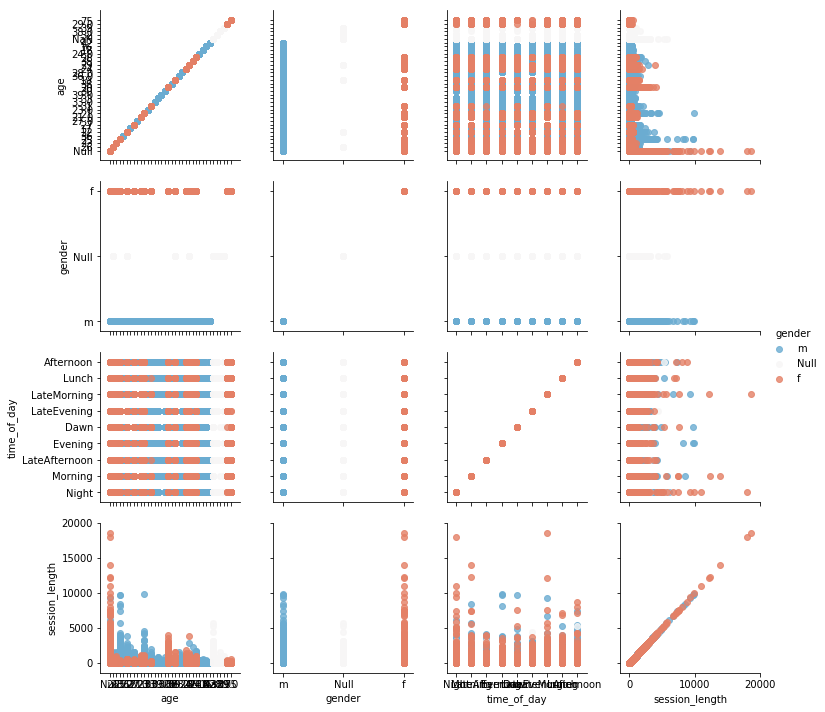

In [170]:
g = sns.PairGrid(plot_df2, vars=['age', 'gender', 'time_of_day', 'session_length'],hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

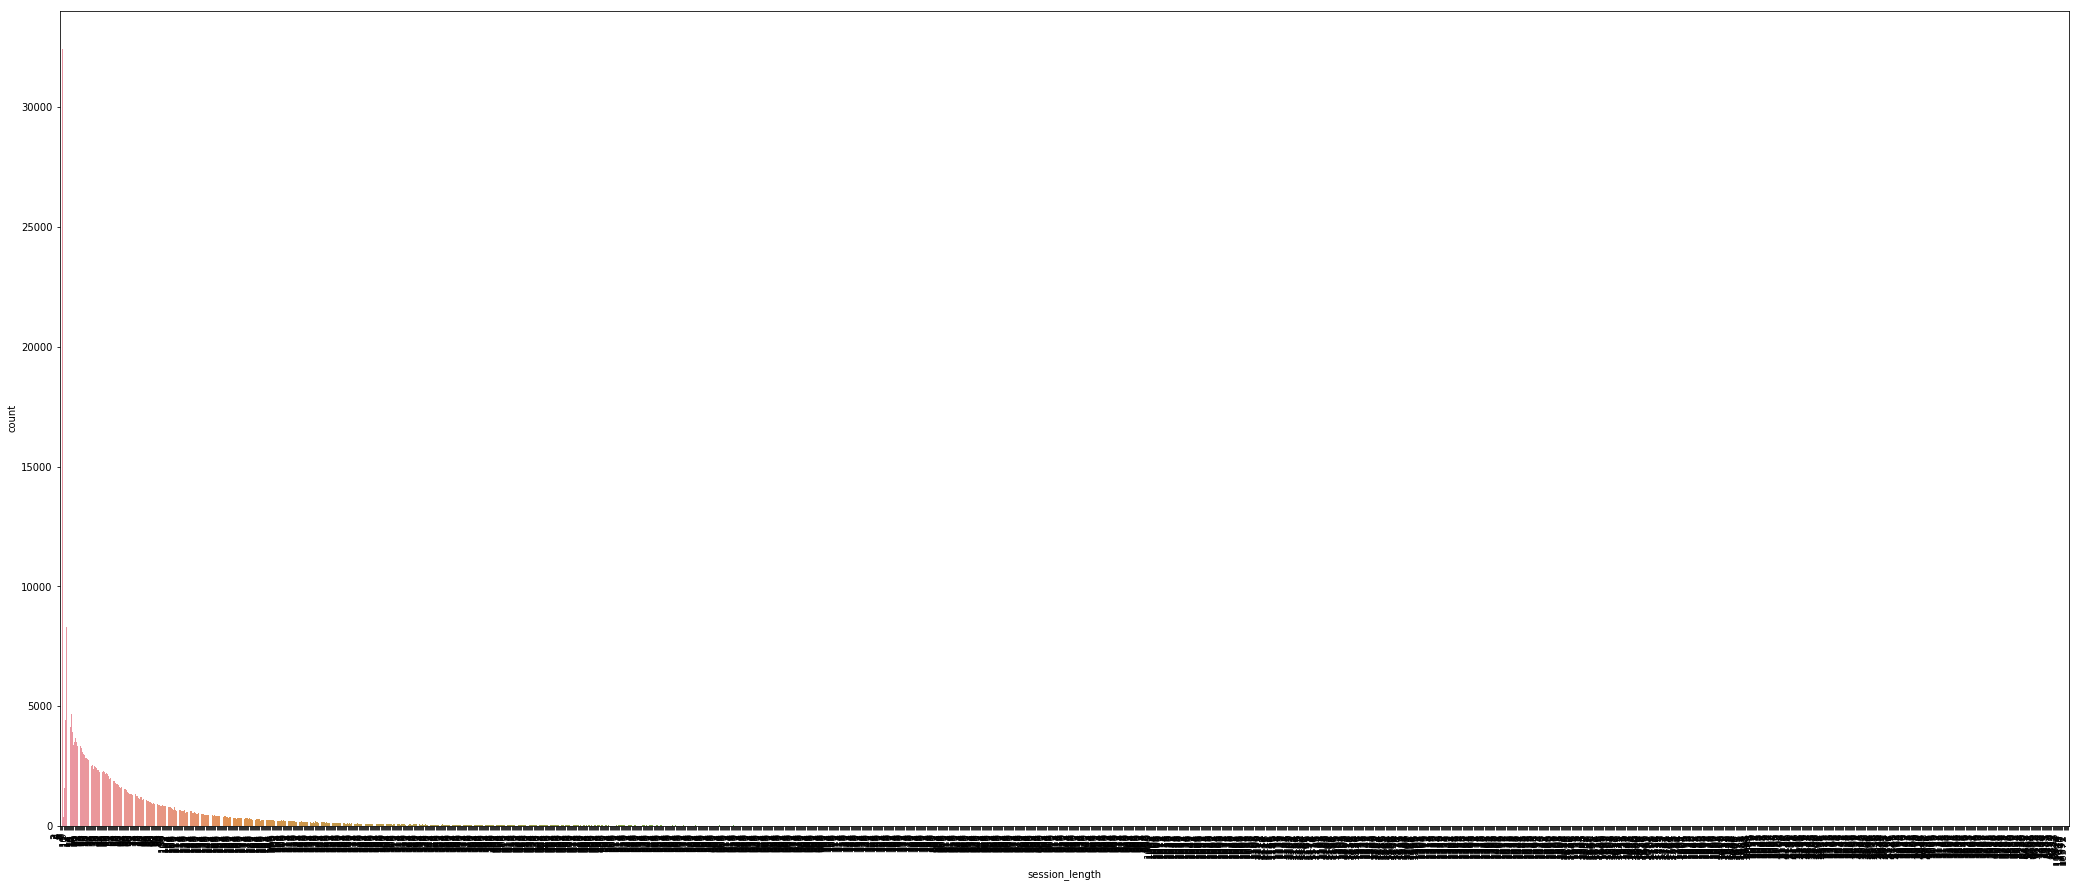

In [171]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 15)
sns.countplot(plot_df['session_length'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

In [172]:
userSession_df = userSession_df.withColumn('log_sess', round(log("session_length"),2)).drop('session_length').withColumnRenamed('log_sess','session_length')

In [173]:
userSession_df.show(10, False)

+-----------+----------+----+------+------------+---------+-------------+-----------+-----------------+-------------+-----------------+----------+-----------+-----------------+-----------+---------------+-----------+-----------+----------+-----------+-------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+------------+----------------+----------------+--------------+
|userid     |session_id|age |gender|gender_index|country  |country_index|day_of_week|day_of_week_index|time_of_day  |time_of_day_index|is_holiday|genre_10   |genre_9          |genre_8    |genre_7        |genre_6    |genre_5    |genre_4   |genre_3    |genre_2|genre_1         |undefined_genre |genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefined_genre_freq|absence_time|days_since_epoch|session_length_1|

In [174]:
#w = Window.partitionBy("userid").orderBy("window").rowsBetween(Window.unboundedPreceding,Window.currentRow)
#(user_session_with_window_df.withColumn("cumSum", sum("session_length").over(w)).show())

In [175]:
plot_log_df = userSession_df.toPandas()

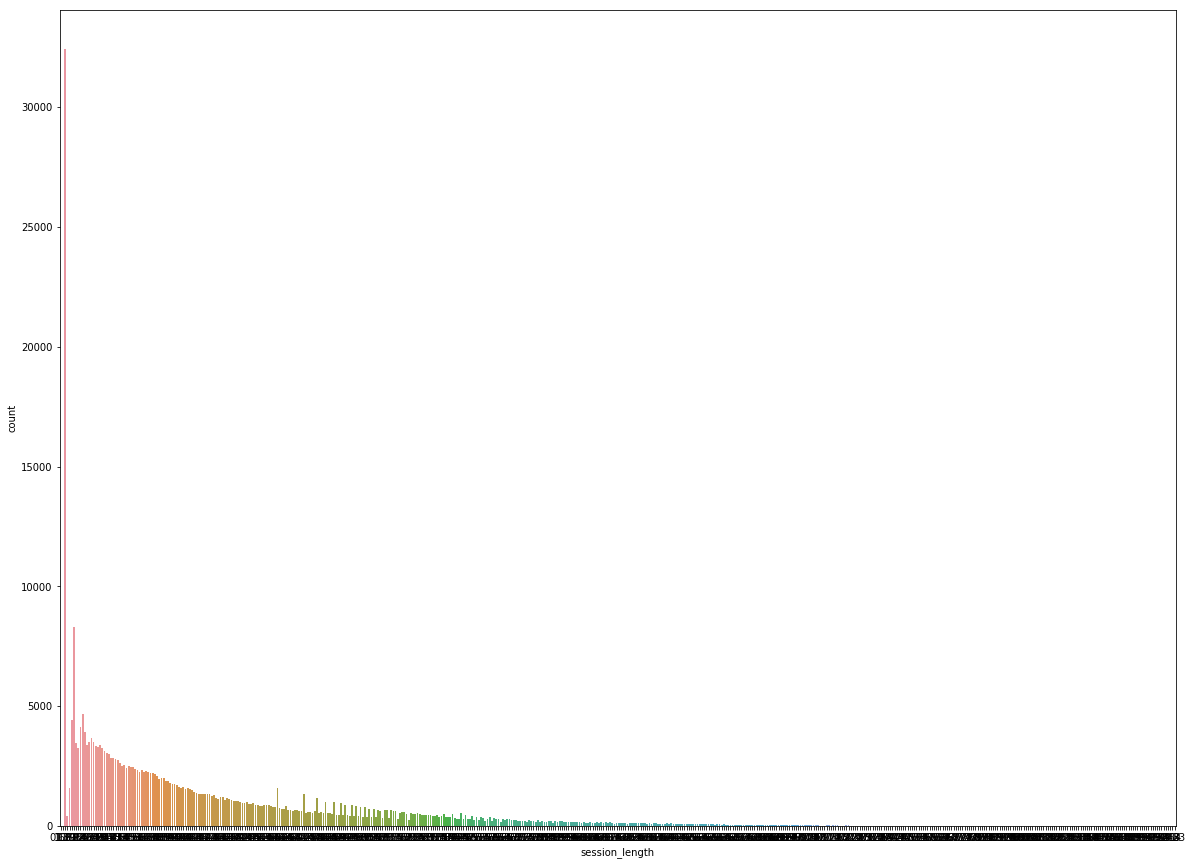

In [176]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
sns.countplot(plot_log_df['session_length'])

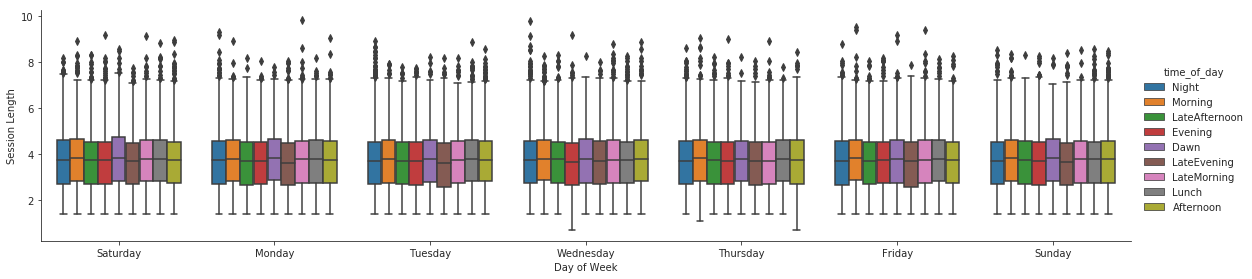

In [177]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("day_of_week", "session_length", "time_of_day", data=plot_log_df, kind="box", size=4, aspect=4)
    g.set_axis_labels("Day of Week", "Session Length")

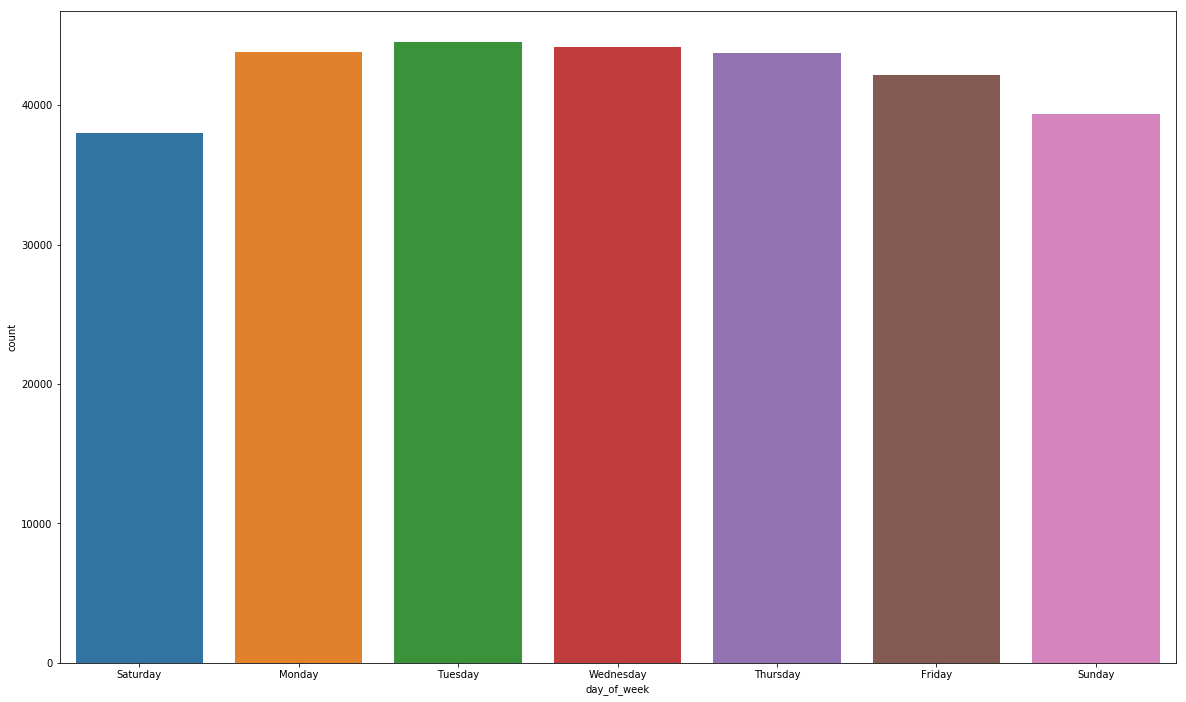

In [184]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
sns.countplot(plot_df['day_of_week'])

In [179]:
sess_tod_df = userSession_df.groupBy('time_of_day').agg(count("time_of_day").alias("num_sessions"))
sess_tod_df.show()

+-------------+------------+
|  time_of_day|num_sessions|
+-------------+------------+
|      Evening|       41963|
|         Dawn|       16312|
|  LateEvening|       22599|
|  LateMorning|       27191|
|      Morning|       30984|
|    Afternoon|       49618|
|        Lunch|       30420|
|        Night|       43932|
|LateAfternoon|       32714|
+-------------+------------+



In [193]:
timeofday    = list([x[0] for x in pd.Series(sess_tod_df.select('time_of_day').collect())])
num_sessions = list([y[0] for y in pd.Series(sess_tod_df.select('num_sessions').collect())])

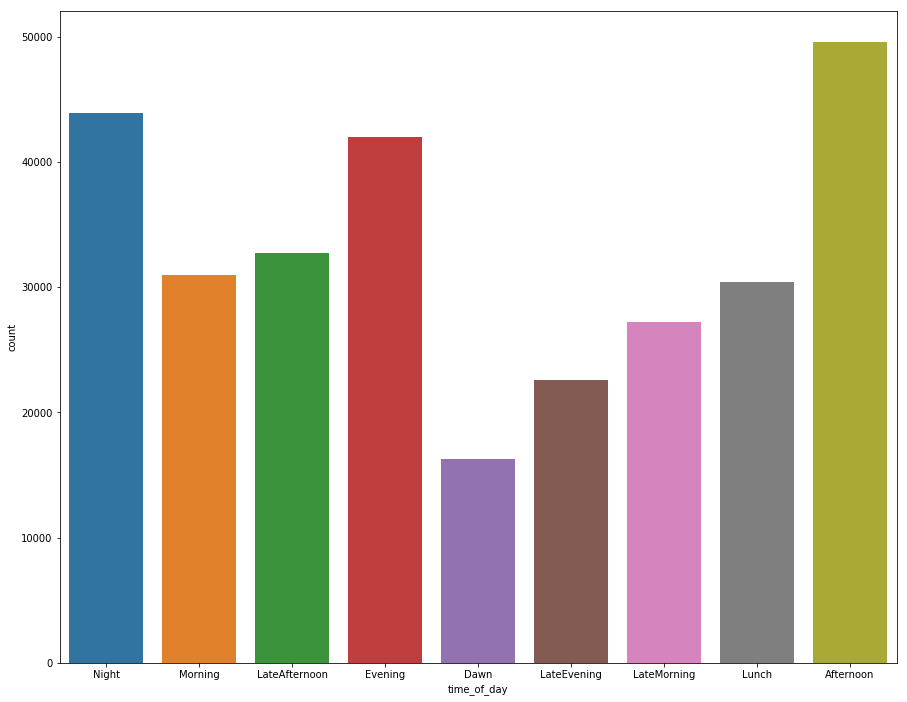

In [183]:
fig, ax = plt.subplots()
fig.set_size_inches(15,12)
sns.countplot(plot_df['time_of_day'])

In [190]:
sess_tod_sl_df = userSession_df.groupBy('time_of_day').agg(round(avg("session_length"),2).alias("avg_sess_length"))
sess_tod_sl_df.show()

+-------------+---------------+
|  time_of_day|avg_sess_length|
+-------------+---------------+
|      Evening|           3.62|
|         Dawn|           3.71|
|  LateEvening|           3.59|
|  LateMorning|           3.67|
|      Morning|           3.72|
|    Afternoon|           3.66|
|        Lunch|           3.69|
|        Night|           3.64|
|LateAfternoon|           3.63|
+-------------+---------------+



In [194]:
avg_sess_len = list([z[0] for z in pd.Series(sess_tod_sl_df.select('avg_sess_length').collect())])

In [196]:
avg_sess_len

[3.62, 3.71, 3.59, 3.67, 3.72, 3.66, 3.69, 3.64, 3.63]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69ff728490>]],
      dtype=object)

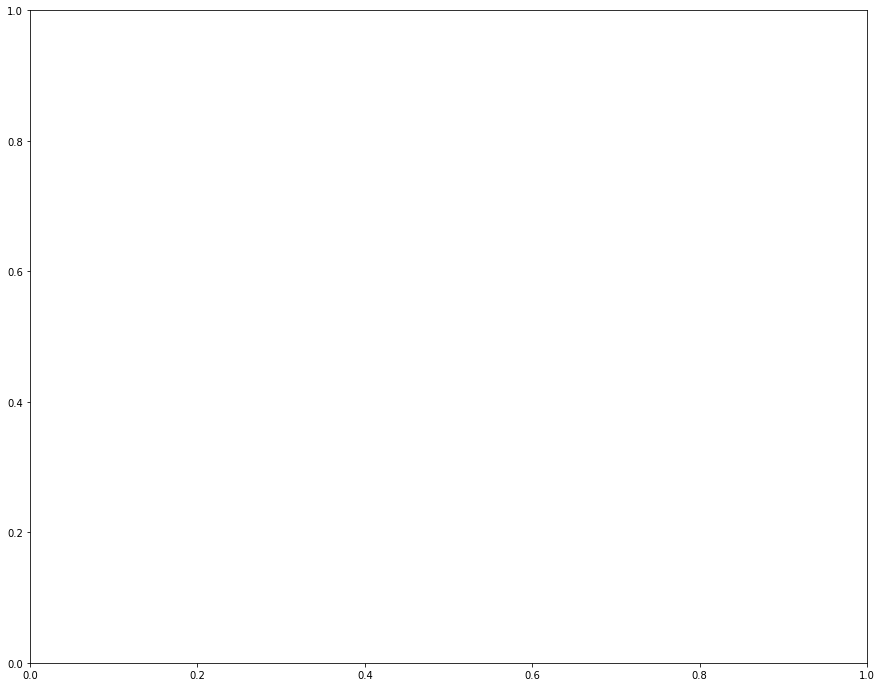

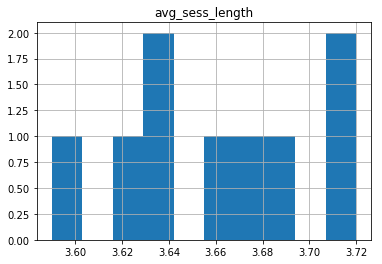

In [199]:
fig, ax = plt.subplots()
fig.set_size_inches(15,12)


In [ ]:
plt.bar()

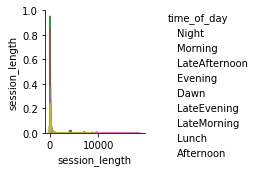

In [186]:

sns.pairplot(plot_df2, hue='time_of_day', size=2.5)
plt.show()

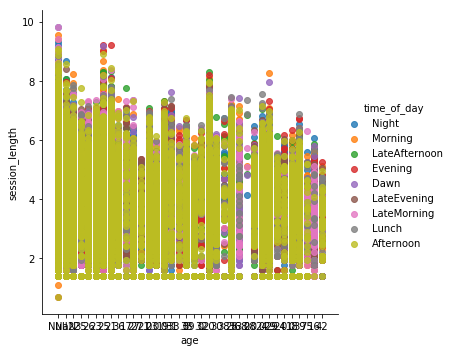

In [200]:
sns.lmplot("age", "session_length", data=plot_log_df, hue='time_of_day', fit_reg=False)

TypeError: can't multiply sequence by non-int of type 'float'

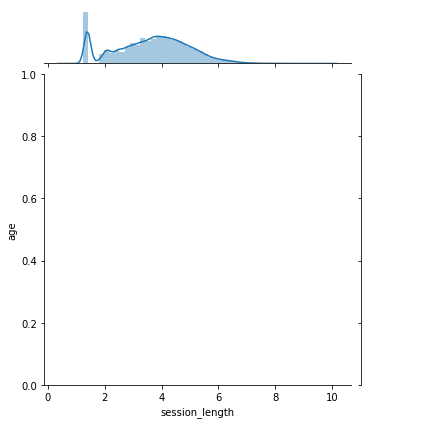

In [219]:
sns.jointplot("session_length", "age", data=plot_log_df.dropna(), kind='reg');

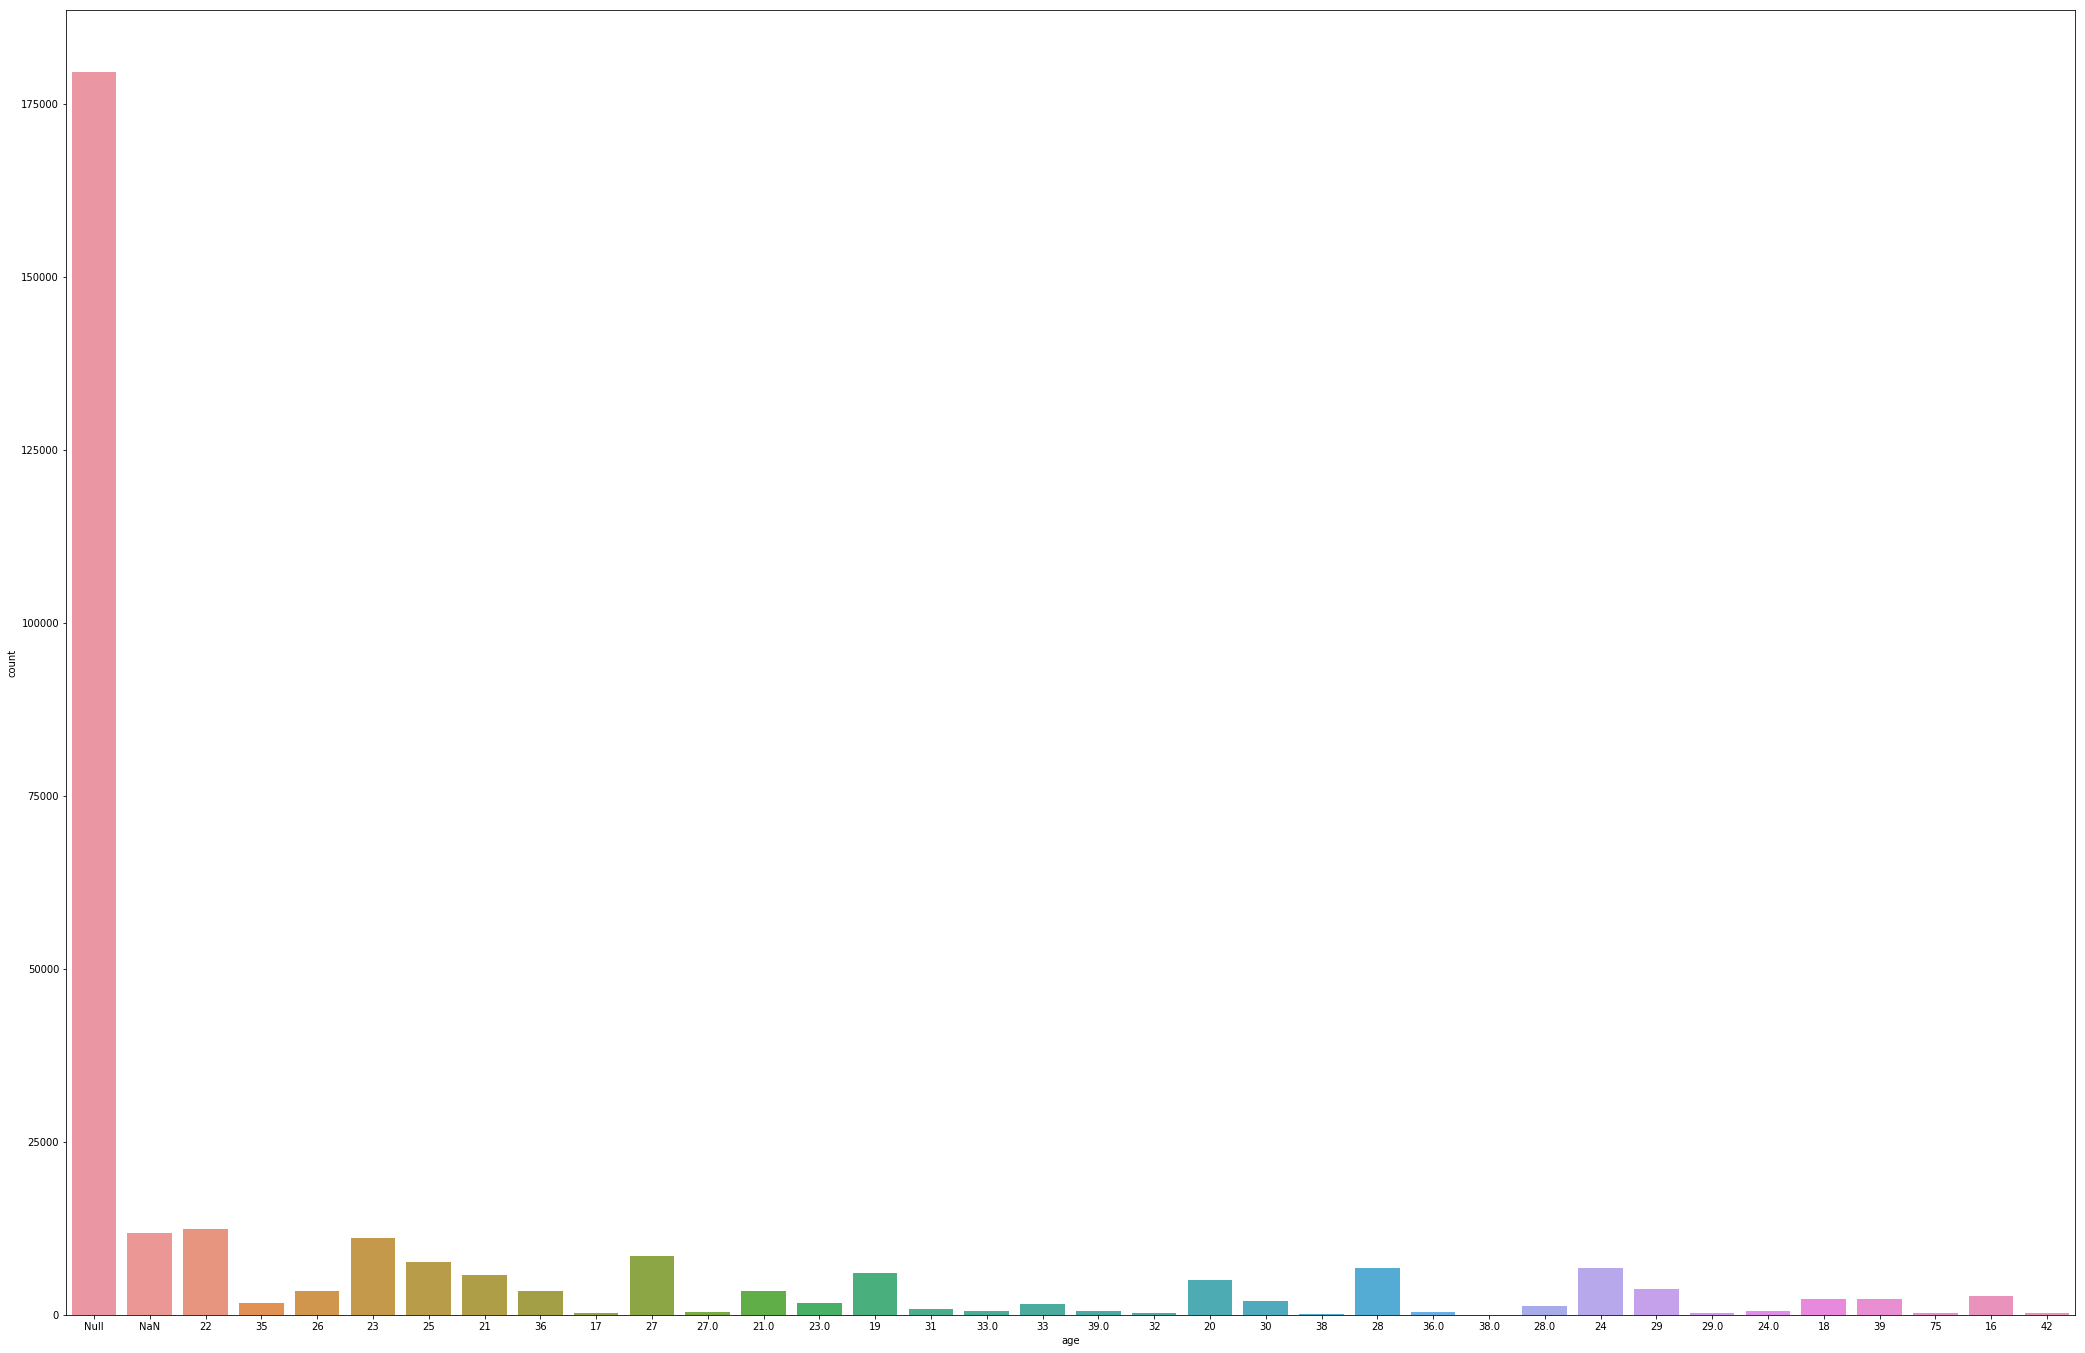

In [220]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 24)
sns.countplot(plot_log_df['age'])

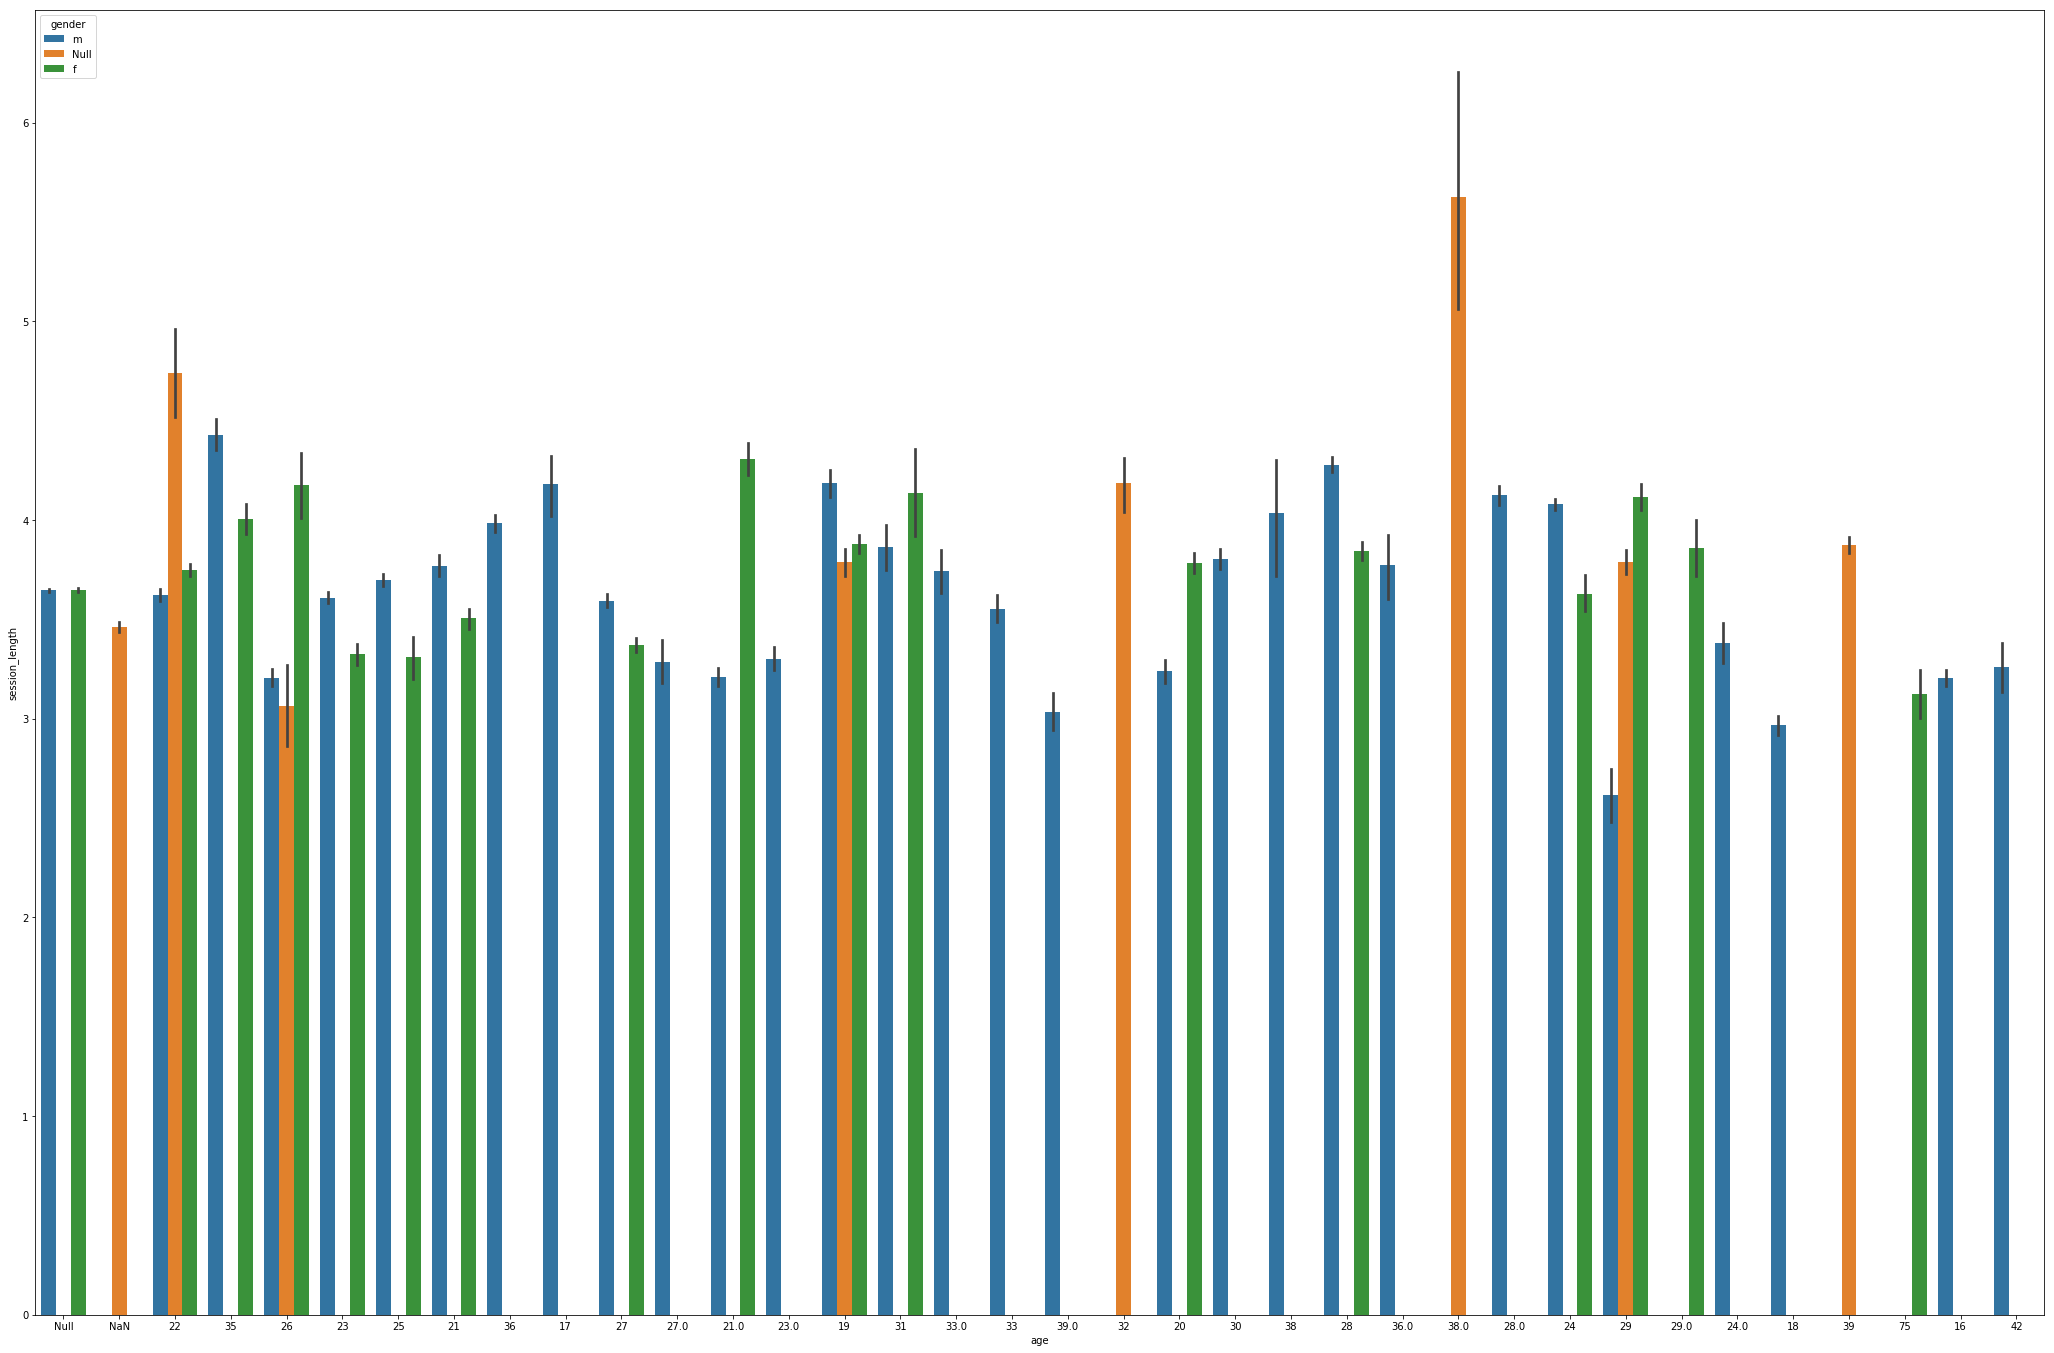

In [221]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 24)
sns.barplot(x="age", y="session_length", hue="gender", data=plot_log_df)

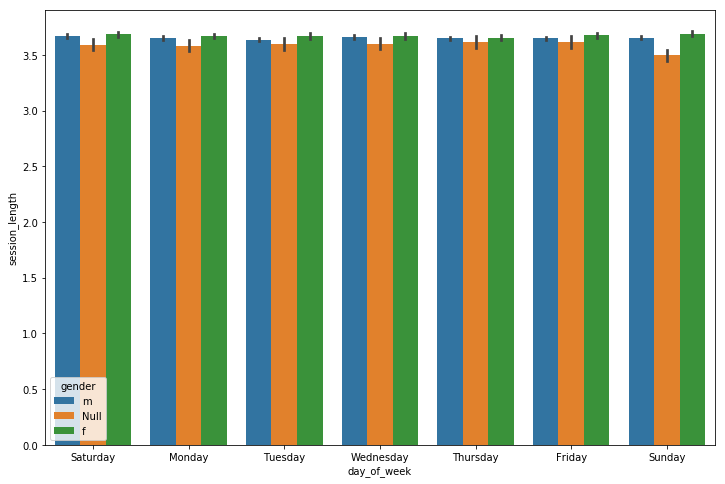

In [222]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.barplot(x="day_of_week", y="session_length", hue="gender", data=plot_log_df)

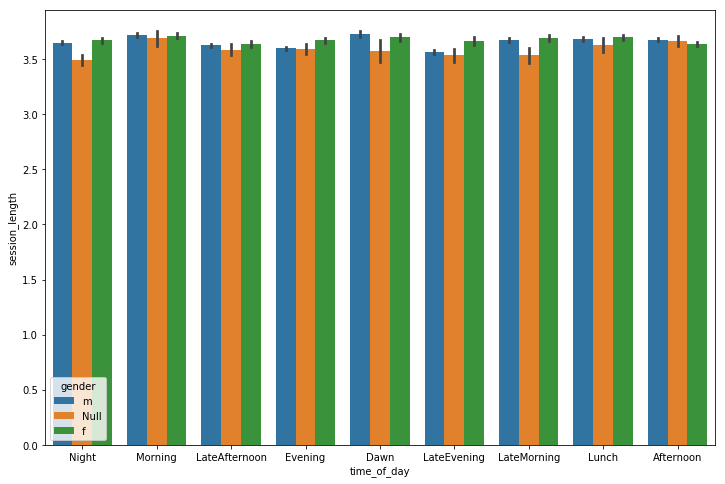

In [223]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.barplot(x="time_of_day", y="session_length", hue="gender", data=plot_log_df)

In [ ]:
cols = ['age']
fig, ax = plt.subplots()
fig.set_size_inches(24, 12)
for col in cols:
    sns.kdeplot(plot_log_df[col], shade=True)

In [ ]:
#sns.kdeplot(plot_log_df.session_length[plot_log_df.gender=='M'], label='men', shade=True)
#sns.kdeplot(plot_log_df.session_length[plot_log_df.gender=='W'], label='women', shade=True)
#plt.xlabel('split_frac');

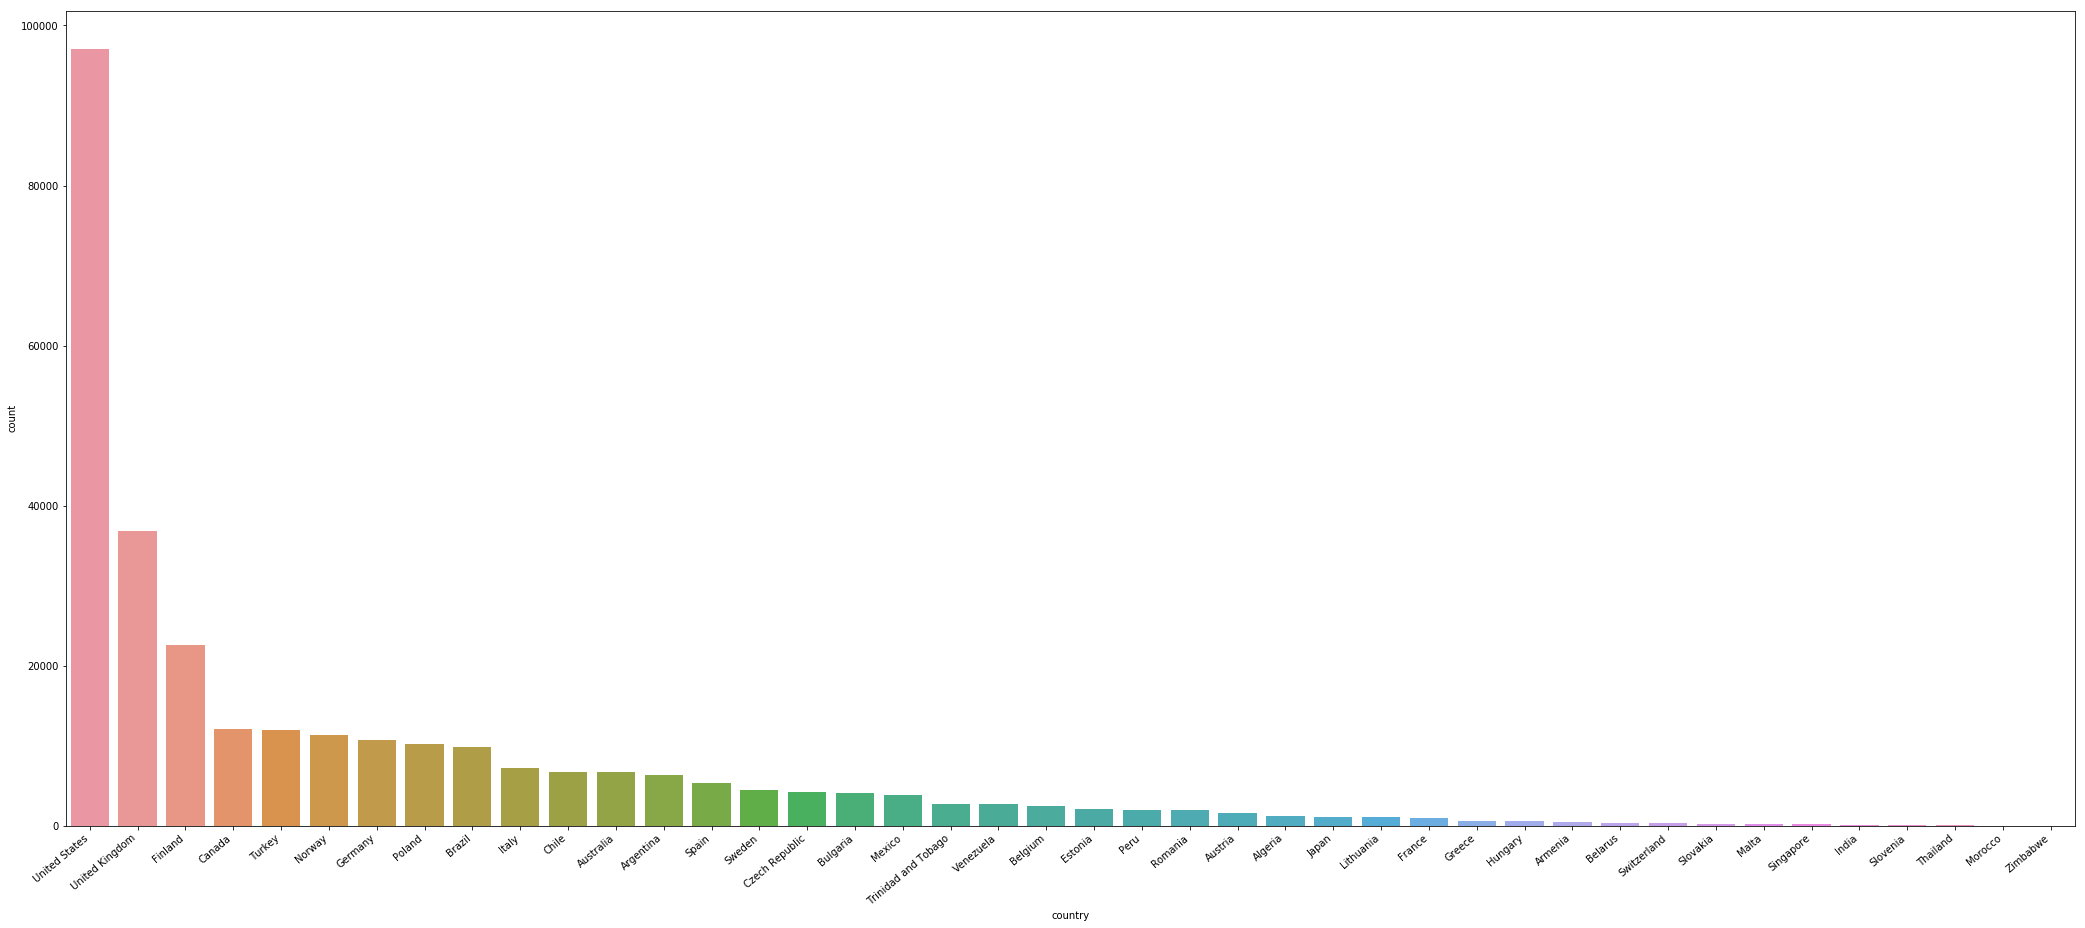

In [229]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 15)
sns.countplot(plot_log_df['country'], order = plot_log_df['country'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

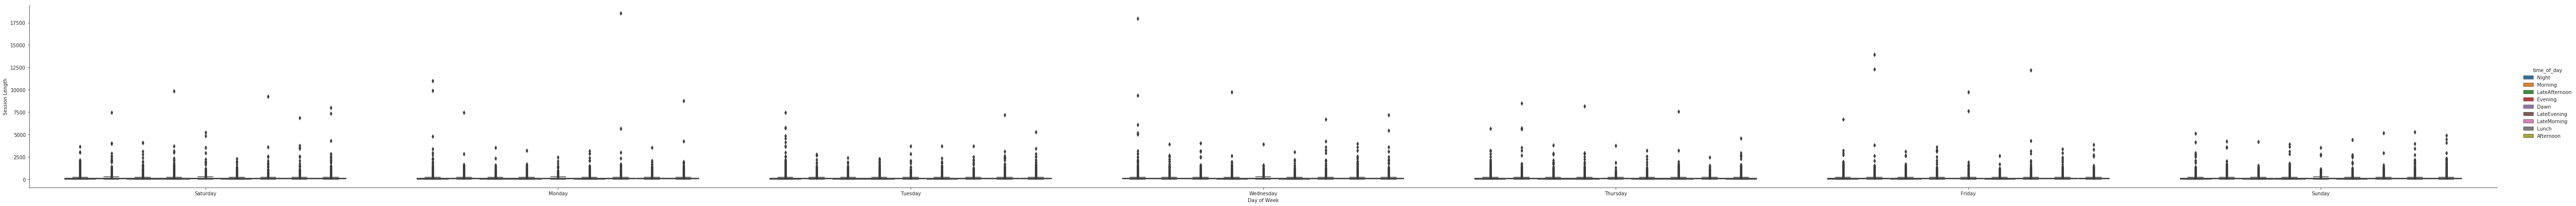

In [232]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("day_of_week", "session_length", "time_of_day", data=plot_df, kind="box", size=6, aspect=12)
    g.set_axis_labels("Day of Week", "Session Length")

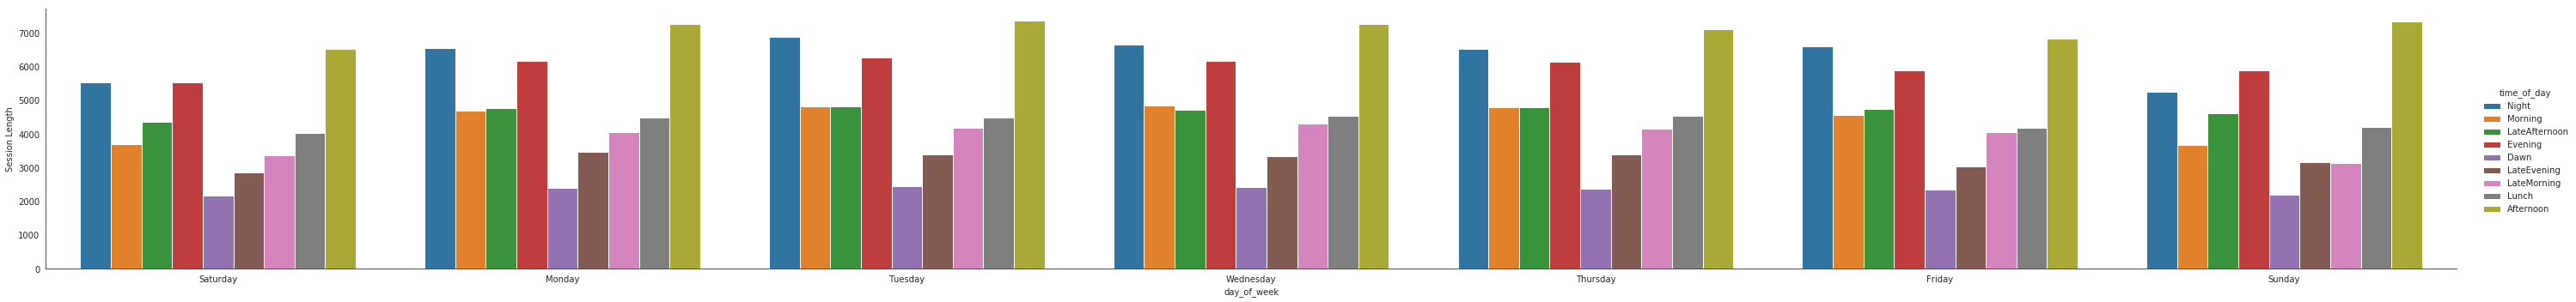

In [227]:
with sns.axes_style('white'):
    g = sns.factorplot("day_of_week", data=plot_log_df, aspect=8.0, kind='count',
                       hue='time_of_day')
    g.set_ylabels('Session Length')

## CLASSIFICATION

In [233]:
data = userSession_df.select('session_length').rdd.map(lambda row: row.session_length).collect()
data[:10]

[1.39, 1.39, 1.95, 3.66, 1.39, 3.18, 4.38, 3.76, 1.39, 3.85]

In [234]:
data = pd.DataFrame(data,columns=['session_length']).iloc[:,0]

In [235]:
data.head(10)

0    1.39
1    1.39
2    1.95
3    3.66
4    1.39
5    3.18
6    4.38
7    3.76
8    1.39
9    3.85
Name: session_length, dtype: float64

In [236]:
data.describe()

count    295733.000000
mean          3.655479
std           1.306022
min           0.690000
25%           2.770000
50%           3.760000
75%           4.570000
max           9.830000
Name: session_length, dtype: float64

In [237]:
deciles = list(np.percentile(data, np.arange(0, 100, 10)))
deciles

[0.69, 1.3899999999999997, 2.48, 3.0, 3.4, 3.76, 4.06, 4.39, 4.77, 5.28]

#### Add Quantile Bucketized Column

In [238]:
userSession_df.show()

+-----------+----------+----+------+------------+---------+-------------+-----------+-----------------+-------------+-----------------+----------+-----------------+-----------------+---------------+----------------+---------------+---------------+-----------------+-----------+-----------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+------------+----------------+----------------+--------------+
|     userid|session_id| age|gender|gender_index|  country|country_index|day_of_week|day_of_week_index|  time_of_day|time_of_day_index|is_holiday|         genre_10|          genre_9|        genre_8|         genre_7|        genre_6|        genre_5|          genre_4|    genre_3|    genre_2|         genre_1| undefined_genre|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefine

In [295]:
#userSession_df.show()

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|                null|           

In [239]:
num_windows = int(userSession_df.select('session_length').distinct().count())
num_windows

510

In [240]:
num_buckets = len(deciles)
num_buckets

10

In [241]:
session_length_bucketizer = QuantileDiscretizer(numBuckets=num_buckets, inputCol="session_length", outputCol="decile", relativeError=0.01, handleInvalid="error")
bucketizer = session_length_bucketizer.fit(userSession_df)
user_session_with_window_bucketized_df = bucketizer.setHandleInvalid("skip").transform(userSession_df)
user_session_with_window_bucketized_df.show()


+-----------+----------+----+------+------------+---------+-------------+-----------+-----------------+-------------+-----------------+----------+-----------------+-----------------+---------------+----------------+---------------+---------------+-----------------+-----------+-----------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+------------+----------------+----------------+--------------+------+
|     userid|session_id| age|gender|gender_index|  country|country_index|day_of_week|day_of_week_index|  time_of_day|time_of_day_index|is_holiday|         genre_10|          genre_9|        genre_8|         genre_7|        genre_6|        genre_5|          genre_4|    genre_3|    genre_2|         genre_1| undefined_genre|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|u

In [242]:
user_session_with_window_bucketized_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- session_id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- gender_index: double (nullable = false)
 |-- country: string (nullable = true)
 |-- country_index: double (nullable = false)
 |-- day_of_week: string (nullable = true)
 |-- day_of_week_index: double (nullable = false)
 |-- time_of_day: string (nullable = true)
 |-- time_of_day_index: double (nullable = false)
 |-- is_holiday: integer (nullable = true)
 |-- genre_10: string (nullable = true)
 |-- genre_9: string (nullable = true)
 |-- genre_8: string (nullable = true)
 |-- genre_7: string (nullable = true)
 |-- genre_6: string (nullable = true)
 |-- genre_5: string (nullable = true)
 |-- genre_4: string (nullable = true)
 |-- genre_3: string (nullable = true)
 |-- genre_2: string (nullable = true)
 |-- genre_1: string (nullable = true)
 |-- undefined_genre: string (nullable = true)
 |-- genre_10_freq: double (nullable = true)

In [243]:
decile_dict = {1.0:"<5_mins",2.0:"<5_mins",3.0:"<10_mins",4.0:"<20_mins",5.0:"<30_mins",6.0:"<40_mins",7.0:"<1_hour",8.0:"<1.5_hours",9.0:"<2_hours",10.0:">3_hours"}

In [244]:
decile_dict

{1.0: '<5_mins',
 2.0: '<5_mins',
 3.0: '<10_mins',
 4.0: '<20_mins',
 5.0: '<30_mins',
 6.0: '<40_mins',
 7.0: '<1_hour',
 8.0: '<1.5_hours',
 9.0: '<2_hours',
 10.0: '>3_hours'}

In [245]:
def get_description(decile):
    try:
        return decile_dict[decile]
    except:
        return None

In [246]:
get_description(1.0)

'<5_mins'

In [247]:
get_desc = udf(lambda bucket: get_description(bucket), returnType=StringType())

In [248]:
user_session_with_window_bucketized_descr_df = user_session_with_window_bucketized_df.withColumn('description', get_desc('decile'))

In [250]:
user_session_with_window_bucketized_descr_df.show(20)

+-----------+----------+----+------+------------+---------+-------------+-----------+-----------------+-------------+-----------------+----------+-----------------+-----------------+---------------+----------------+---------------+---------------+-----------------+-----------+-----------+----------------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+------------+----------------+----------------+--------------+------+-----------+
|     userid|session_id| age|gender|gender_index|  country|country_index|day_of_week|day_of_week_index|  time_of_day|time_of_day_index|is_holiday|         genre_10|          genre_9|        genre_8|         genre_7|        genre_6|        genre_5|          genre_4|    genre_3|    genre_2|         genre_1| undefined_genre|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|ge

In [251]:
train_data = None
dev_data = None
test_data = None

In [252]:
user_session_with_window_bucketized_descr_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- session_id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- gender_index: double (nullable = false)
 |-- country: string (nullable = true)
 |-- country_index: double (nullable = false)
 |-- day_of_week: string (nullable = true)
 |-- day_of_week_index: double (nullable = false)
 |-- time_of_day: string (nullable = true)
 |-- time_of_day_index: double (nullable = false)
 |-- is_holiday: integer (nullable = true)
 |-- genre_10: string (nullable = true)
 |-- genre_9: string (nullable = true)
 |-- genre_8: string (nullable = true)
 |-- genre_7: string (nullable = true)
 |-- genre_6: string (nullable = true)
 |-- genre_5: string (nullable = true)
 |-- genre_4: string (nullable = true)
 |-- genre_3: string (nullable = true)
 |-- genre_2: string (nullable = true)
 |-- genre_1: string (nullable = true)
 |-- undefined_genre: string (nullable = true)
 |-- genre_10_freq: double (nullable = true)

In [257]:
from pyspark.sql.functions import percent_rank

def get_train_dev_test_data():
    print("==================================================================================================================")
    print("============================================     CREATE TRAIN/DEV/TEST SETS      =================================")
    print("==================================================================================================================\n\n")
    global train_data, dev_data, test_data
    global user_session_with_window_df
    
    print("SESSION_DATA_WITH_WINDOW_BUCKETIZED_DESCR_DF.USERID.COUNT():\t{}".format(user_session_with_window_bucketized_descr_df.select("userid").distinct().count()))
    session_data = user_session_with_window_bucketized_descr_df.select("userid","gender","age","country", "day_of_week", "time_of_day","is_holiday","genre_10","genre_9","genre_8","genre_7","genre_6","genre_5","genre_4","genre_3","genre_2","genre_1","genre_10_freq","genre_9_freq","genre_8_freq","genre_7_freq","genre_6_freq","genre_5_freq","genre_4_freq","genre_3_freq","genre_2_freq","genre_1_freq","absence_time","days_since_epoch","session_length_1","session_length","decile").na.drop()
    print("SESSION_DATA.USERID.COUNT():\t{}".format(session_data.select("userid").distinct().count()))
    categoricalColumns = ["userid","gender","country", "day_of_week", "time_of_day","genre_10","genre_9","genre_8","genre_7","genre_6","genre_5","genre_4","genre_3","genre_2","genre_1"]
    cols = session_data.columns
    stages =[]
    for categoricalCol in categoricalColumns:
        stringIndexer  = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"classVec"])
        stages += [stringIndexer,encoder]
    label_stringIdx = StringIndexer(inputCol="decile", outputCol="label")
    stages += [label_stringIdx]
    numericCols = ["is_holiday","genre_10_freq","genre_9_freq","genre_8_freq","genre_7_freq","genre_6_freq","genre_5_freq","genre_4_freq","genre_3_freq","genre_2_freq","genre_1_freq","is_holiday","absence_time","days_since_epoch","session_length_1","session_length","decile"]
    assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(session_data)
    session_data = pipelineModel.transform(session_data)
    selectedcols = ["label","features"] + cols
    session_data = session_data.select(selectedcols)
    print("************************************       DATA BEFORE TRAIN/DEV/TEST SPLIT     *************************************")
    #session_data.show(5,False)
    print("************************************           Splitting Train/Test data        *************************************")
    #train_data, dev_data, test_data = session_data.randomSplit([0.65, 0.2, 0.15])
    
    print("SESSION_DATA.COUNT():\t{}".format(session_data.count()))
    print("SESSION_DATA.USERID.COUNT():\t{}".format(session_data.select("userid").distinct().count()))

    session_data_df = session_data.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("userid")))
    train_data = session_data_df.where("rank <= .65").drop("rank")
    #train_data.show()
    dev_data = session_data_df.where(("rank > .65") and ("rank < 0.799")).drop("rank")
    #dev_data.show()
    test_data = session_data_df.where("rank > .80").drop("rank")
    #test_data.show()

In [258]:
get_train_dev_test_data()

============================================     CREATE TRAIN/DEV/TEST SETS      =================================


SESSION_DATA_WITH_WINDOW_BUCKETIZED_DESCR_DF.USERID.COUNT():	327
SESSION_DATA.USERID.COUNT():	327
************************************       DATA BEFORE TRAIN/DEV/TEST SPLIT     *************************************
************************************           Splitting Train/Test data        *************************************
SESSION_DATA.COUNT():	295406
SESSION_DATA.USERID.COUNT():	327


In [259]:
train_data.show(5,False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------+-----------+-----------+----------+---------------+---------------+---------------+---------------+---------------+-----------+-----------+-----------+-------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------------+----------------+--------------+------+
|label|features                                                                                                                                                                                                                                                                                       

In [260]:
dev_data.show(5,False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------+-----------+-----------+----------+---------------+---------------+---------------+---------------+---------------+-----------+-----------+-----------+-------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------------+----------------+--------------+------+
|label|features                                                                                                                                                                                                                                                                                       

In [261]:
test_data.show(5,False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------------+-----------+-----------+----------+---------------+---------------+---------+----------+-------------------+-----------+-----------+-----------+-------+----------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------------+----------------+--------------+------+
|label|features                                                                                                                                                                                                                                                                                      |user

### BASELINE DL model with Multinomial Naive Bayes

In [262]:
smoothings  = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [263]:
mnbModel = None

In [273]:
def mnb_classifier(smoothing):
    global mnbModel
    global lr_results
    global train_data, dev_data, test_data
    mnb = NaiveBayes(smoothing=smoothing, modelType="multinomial")
    #print("---------------------------------  Fitting Model to TRAIN  ---------------------------")
    mnbModel = mnb.fit(train_data)
    #print("---------------------------------  Generating Predictions  ---------------------------")
    predictions = mnbModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "gender","is_holiday","country", "day_of_week", "time_of_day","genre_10","genre_9","genre_8","genre_7","genre_6","genre_5","genre_4","genre_3","genre_2","genre_1",
                                  "genre_10_freq","genre_9_freq","genre_8_freq","genre_7_freq","genre_6_freq","genre_5_freq","genre_4_freq","genre_3_freq","genre_2_freq","genre_1_freq","absence_time","days_since_epoch","session_length_1","session_length","decile")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    #print("---------------------------------  Evaluating Model     ------------------------------")
    result = evaluator.evaluate(mnbModel.transform(dev_data))
    #result.select("features","label","prediction").show(5,False)
    mnb_results.update({smoothing:result})


In [274]:
def eval_mnb_classifier():
    print("###########################################################################################")
    print("############################     MULTINOMIAL NAIVE BAYES CLASSIFIER      ##################")
    print("###########################################################################################")
    print("\tSMOOTHING\tACCURACY")
    for smoothing in smoothings:
        mnb_classifier(smoothing)
        print("\t{}\t\t{}".format(smoothing, mnb_results[smoothing]))
        

In [275]:
mnb_results = dict()

eval_mnb_classifier()

###########################################################################################
############################     MULTINOMIAL NAIVE BAYES CLASSIFIER      ##################
###########################################################################################
	SMOOTHING	ACCURACY
	0.1		0.142868622616
	0.2		0.142843246307
	0.3		0.142813640612
	0.4		0.142784034918
	0.5		0.142784034918
	0.6		0.142775576148
	0.7		0.142754429223
	0.8		0.142750199838
	0.9		0.142750199838
	1.0		0.142724823529


### BASELINE DL model with Multinomial Logistic Regression

In [323]:
lrModel = None

In [276]:
def logistic_classifier(regparam, elasticnetparam):
    global lrModel
    global lr_results
    global train_data, dev_data, test_data
    lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=regparam, elasticNetParam=elasticnetparam)
    #print("---------------------------------  Fitting Model to TRAIN  ---------------------------")
    lrModel = lr.fit(train_data)
    #print("---------------------------------  Generating Predictions  ---------------------------")
    predictions = lrModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "gender","is_holiday","country", "day_of_week", "time_of_day","genre_10","genre_9","genre_8","genre_7","genre_6","genre_5","genre_4","genre_3","genre_2","genre_1",
                                  "genre_10_freq","genre_9_freq","genre_8_freq","genre_7_freq","genre_6_freq","genre_5_freq","genre_4_freq","genre_3_freq","genre_2_freq","genre_1_freq","absence_time","days_since_epoch","session_length_1","session_length")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    #print("---------------------------------  Evaluating Model     ------------------------------")
    result = evaluator.evaluate(lrModel.transform(dev_data))
    #result.select("features","label","prediction").show(5,False)
    lr_results.update({elasticnetparam:{regparam:result}})
    #print("MULTINOMIAL LOGISTIC REGRESSION RESULTS:\t{}".format(lr_results))

In [280]:
regparams        = [0.0000000001,  0.000001,  0.01, 0.1, 0.5]
elasticnetparams = [0.0000000001,  0.000001,  0.01, 0.1, 0.5]

In [281]:
def eval_mlr_classifier():
    print("###########################################################################################")
    print("###############################         LOGISTIC REGRESSION         #######################")
    print("###########################################################################################")
    print("\tREGPARAM\tELASTICNETPARAM\t\tACCURACY")
    for regparam in regparams:
        for elasticnetparam in elasticnetparams:
            logistic_classifier(regparam, elasticnetparam)
            print("\t{}\t\t\t{}\t\t{}".format(regparam, elasticnetparam,lr_results))
        

In [282]:
lr_results = {}
eval_mlr_classifier()

###########################################################################################
###############################         LOGISTIC REGRESSION         #######################
###########################################################################################
	REGPARAM	ELASTICNETPARAM		ACCURACY
	1e-10			1e-10		{1e-10: {1e-10: 0.4239197093566683}}
	1e-10			1e-06		{1e-06: {1e-10: 0.4239197093566683}, 1e-10: {1e-10: 0.4239197093566683}}
	1e-10			0.01		{1e-06: {1e-10: 0.4239197093566683}, 0.01: {1e-10: 0.4239197093566683}, 1e-10: {1e-10: 0.4239197093566683}}
	1e-10			0.1		{1e-06: {1e-10: 0.4239197093566683}, 0.1: {1e-10: 0.4239197093566683}, 0.01: {1e-10: 0.4239197093566683}, 1e-10: {1e-10: 0.4239197093566683}}
	1e-10			0.5		{0.5: {1e-10: 0.4239197093566683}, 1e-06: {1e-10: 0.4239197093566683}, 0.1: {1e-10: 0.4239197093566683}, 0.01: {1e-10: 0.4239197093566683}, 1e-10: {1e-10: 0.4239197093566683}}
	1e-06			1e-10		{0.5: {1e-10: 0.4239197093566683}, 1e-06: {1e-10: 0.423919709

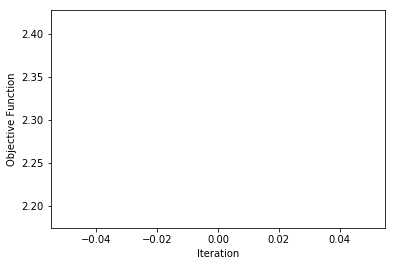

In [283]:
trainingSummary = lrModel.summary

objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

In [284]:
predictions = lrModel.transform(dev_data)
predictions.select("features","label","prediction").show(10, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|features                                                                                                                                                                                                                                                                                         |label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|(2050,[95,326,354,372,376,384,657,939,1173,1378,1580,1754,1894,1991,2032

In [285]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.884724


In [286]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [288]:
predictions.select('userid','gender','age','time_of_day','absence_time','is_holiday','session_length', 'decile','prediction').sample(0.001,100).show(30, False)

+-----------+------+----+-------------+------------+----------+--------------+------+----------+
|userid     |gender|age |time_of_day  |absence_time|is_holiday|session_length|decile|prediction|
+-----------+------+----+-------------+------------+----------+--------------+------+----------+
|user_000001|m     |Null|Morning      |7604        |0         |1.39          |0.0   |0.0       |
|user_000002|f     |Null|Night        |125         |0         |5.11          |8.0   |0.0       |
|user_000003|m     |22  |Morning      |3640        |1         |5.35          |9.0   |0.0       |
|user_000005|m     |Null|Night        |50          |0         |1.39          |0.0   |0.0       |
|user_000005|m     |Null|LateEvening  |119         |0         |1.39          |0.0   |0.0       |
|user_000012|f     |28  |LateAfternoon|299         |0         |5.53          |9.0   |0.0       |
|user_000012|f     |28  |Night        |602         |0         |2.71          |2.0   |0.0       |
|user_000021|m     |27  |LateM

In [289]:
class_temp  = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp

,label,count
0,0.0,27256
1,1.0,25369
2,2.0,24764
3,3.0,23584
4,4.0,23350
5,5.0,23185
6,6.0,22785
7,7.0,22592
8,8.0,22583
9,9.0,20973


In [290]:
class_names = class_temp['label']

In [291]:
class_names

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
6    6.0
7    7.0
8    8.0
9    9.0
Name: label, dtype: float64

### Manually Create Confusion Matrix

In [292]:
df = predictions.select('label','prediction')
df.show()

+-----+----------+
|label|prediction|
+-----+----------+
|  9.0|       0.0|
|  4.0|       0.0|
|  2.0|       0.0|
|  9.0|       0.0|
|  1.0|       0.0|
|  9.0|       0.0|
|  2.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  7.0|       0.0|
|  5.0|       0.0|
|  2.0|       0.0|
|  5.0|       0.0|
|  6.0|       0.0|
|  5.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  9.0|       0.0|
+-----+----------+
only showing top 20 rows



In [293]:
print("\tLABEL\tLabels\tPredictions")
for label in class_names:
    num_labels = df[df['label'] == label].count()
    num_correct_preds = df[(df['label'] == label) & (df['prediction'] == label)].count()
    print("\t{}\t{}\t{}".format(label,num_labels,num_correct_preds))

	LABEL	Labels	Predictions
	0.0	27256	27256
	1.0	25369	0
	2.0	24764	0
	3.0	23584	0
	4.0	23350	0
	5.0	23185	0
	6.0	22785	0
	7.0	22592	0
	8.0	22583	0
	9.0	20973	0


In [294]:
predictions_rdd = predictions.select('prediction','label').rdd.map(tuple)

In [295]:
predictions_rdd.take(5)

[(0.0, 9.0), (0.0, 4.0), (0.0, 2.0), (0.0, 9.0), (0.0, 1.0)]

In [296]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics



In [297]:
metrics = MulticlassMetrics(predictions_rdd.map(tuple))

IllegalArgumentException: u"Error while instantiating 'org.apache.spark.sql.internal.SessionStateBuilder':"

In [298]:


# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = \t\t%s" % precision)
print("Recall = \t\t%s" % recall)
print("F1 Score = \t\t%s" % f1Score)

# Statistics by class
#labels = data.map(lambda lp: lp.label).distinct().collect()
labels = class_names
for label in sorted(labels):
    print("Class %s precision = \t%s" % (label, metrics.precision(label)))
    print("Class %s recall = \t%s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = \t%s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("Weighted recall = \t%s" % metrics.weightedRecall)
print("Weighted precision = \t%s" % metrics.weightedPrecision)
print("Weighted F(1) Score = \t%s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Exception AttributeError: "'MulticlassMetrics' object has no attribute '_sc'" in <bound method MulticlassMetrics.__del__ of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f69f9ee4310>> ignored


NameError: name 'metrics' is not defined

In [299]:
m = metrics.confusionMatrix()

NameError: name 'metrics' is not defined

In [348]:
from pyspark.mllib.linalg import Vectors, DenseMatrix 

import seaborn as sns
sns.set() 


def display_cm(m):
  a = m.toArray().astype(np.float)
  row_sums = a.sum(axis=1)
  percentage_matrix = a.astype(np.float) / row_sums[:, np.newaxis]
  print(percentage_matrix)
  plt.figure(figsize=(3, 3))
  sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=['0' ,'1','2'], yticklabels=['0' ,'1','2']);
  plt.title('Confusion Matrix');

[[9.99950296e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.97042597e-05]
 [0.00000000e+00 9.76685873e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.94921041e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.53649168e-02]
 [8.25053996e-01 1.66140555e-04 1.73007698e-01 0.00000000e+00
  0.00000000e+00 1.21836407e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.53801850e-04]
 [1.75922608e-01 8.17389227e-01 2.98578765e-04 0.00000000e+00
  0.00000000e+00 4.47868148e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.91090410e-03]
 [4.09607150e-03 9.84236331e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.40637994e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.26121765e-03]
 [0.00000000e+00 9.67186525e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.15845290e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.12289457e-02]
 [0.00000000e+00 9.70787552e-01 0.00000000e+00 0.00000000e

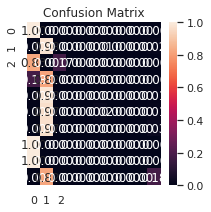

In [349]:
display_cm(m)

### BASELINE DL model with an generic MLP Classifier

In [363]:
train_data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userid: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- country: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- session_length_mvavg: double (nullable = true)
 |-- session_length_mvavg_10: double (nullable = true)
 |-- session_length_mvavg_5: double (nullable = true)
 |-- session_length_mvavg_time: double (nullable = true)
 |-- previous_duration: double (nullable = true)
 |-- absence_time: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- session_length: double (nullable = true)
 |-- decile: double (nullable = true)



In [364]:
def mlp_classifier():
    print("###########################################################################################")
    print("##################################       MLP CLASSIFIER      ##############################")
    print("###########################################################################################")
    global mlp_results
    global train_data, dev_data, test_data
    layer_1 = train_data.schema["features"].metadata["ml_attr"]["num_attrs"]
    layer_2 = layer_1*4
    layer_3 = int(layer_2/2)
    layer_4 = num_buckets
    layers = [layer_1, layer_2, layer_3, layer_4]
    print("LAYERS: \t{}".format(layers))
    print("---------------------------------  Training MLP Model        ------------------------------")
    trainer = MultilayerPerceptronClassifier(maxIter=5, layers=layers, blockSize=128)
    print("---------------------------------  Fitting Model to TRAIN    ------------------------------")
    mlp_model = trainer.fit (train_data)        
    print("---------------------------------  Testing Model against DEV ------------------------------")
    predictions = mlp_model.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "gender","country", "day_of_week", "timeofday", "is_holiday","session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","absence_time","is_holiday","session_length")
    print("evaluator = MulticlassClassificationEvaluator().....")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    print("result = evaluator.evaluate(mlp_model.transform(dev_data))")
    result = evaluator.evaluate(mlp_model.transform(dev_data))
    mlp_results.append(result)
    print("MLP CLASSIFIER RESULTS:\t{}".format(mlp_results))

In [365]:
#mlp_results = []
#mlp_classifier()

### BASELINE Model with Decision Tree Classifier

In [366]:
dt_results = dict()
maxBins = 100


In [300]:
def decisionTree_classifier(max_depth):
    global dt_results
    global train_data, dev_data, test_data
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=max_depth, maxBins=100)
    dtModel = dt.fit(train_data)
    #print("numNodes = ", dtModel.numNodes)
    #print("depth = ", dtModel.depth)
    evaluator = MulticlassClassificationEvaluator().setMetricName ('accuracy').setPredictionCol ('prediction').setLabelCol ('label')
    #print("result = evaluator.evaluate(dfModel.transform(dev_data))")
    result = evaluator.evaluate(dtModel.transform(dev_data))
    #print("dt_results.append(result)")
    dt_results.update({max_depth:result})
    #print("DECISION TREE CLASSIFIER RESULTS:\t{}".format(dt_results))

In [301]:
def eval_dt_classifier():
    print("###########################################################################################")
    print("###############################          DECISION TREE              #######################")
    print("###########################################################################################")
    print("\tNUM_TREES\tMAX_TREE_DEPTH\t\tACCURACY")
    global dt_results
    for max_tree_depth in max_tree_depths:
        decisionTree_classifier(max_tree_depth)
        print("\t\t\t\t{}\t\t{}".format(max_tree_depth,dt_results[max_tree_depth]))
        

In [302]:
max_tree_depths = [1,2,3,4,5,6,7,8,9,10]

In [303]:
dt_results = dict()
eval_dt_classifier()

###########################################################################################
###############################          DECISION TREE              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY
				1		0.222571381444
				2		0.32231719541
				3		0.427053683583
				4		0.623868110861
				5		0.808937536214
				6		0.904449735875
				7		1.0
				8		1.0
				9		1.0
				10		1.0


### BASELINE Model with RandomForest Classifier

In [304]:
rfModel = None
def randomForest_classifier(num_tree, max_tree_depth):
    global rf_results
    global rfModel
    global train_data, dev_data, test_data
    #rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=20, maxBins=100)
    rf = RandomForestClassifier(numTrees=num_tree, featureSubsetStrategy="auto", impurity="gini", labelCol="label", featuresCol="features", maxDepth=max_tree_depth, maxBins=100)
    
    #print("---------------------------------  Fitting Model to Train     ------------------------------")
    rfModel = rf.fit(train_data)
    #print("---------------------------------  Transforming Dev           ------------------------------")
    predictions = rfModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "gender","is_holiday","country", "day_of_week", "time_of_day","genre_10","genre_9","genre_8","genre_7","genre_6","genre_5","genre_4","genre_3","genre_2","genre_1",
                                  "genre_10_freq","genre_9_freq","genre_8_freq","genre_7_freq","genre_6_freq","genre_5_freq","genre_4_freq","genre_3_freq","genre_2_freq","genre_1_freq","absence_time","days_since_epoch","session_length_1","session_length")
    #print("---------------------------------     Evaluating Model        ------------------------------")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setPredictionCol ('prediction').setLabelCol ('label')
    result = evaluator.evaluate(rfModel.transform(dev_data))
    #print("---------------------------------  Summarizing Results        ------------------------------")
    rf_results.update({num_tree:{max_tree_depth:result}})
    #print("RANDOM FOREST CLASSIFIER RESULTS:\t{}".format(rf_results))

In [305]:
def eval_rf_classifier():
    print("###########################################################################################")
    print("###############################          RANDOM FOREST              #######################")
    print("###########################################################################################")
    print("\tNUM_TREES\tMAX_TREE_DEPTH\t\tACCURACY")
    for num_tree in num_trees:
        for max_tree_depth in max_tree_depths:
            randomForest_classifier(num_tree, max_tree_depth)
            print("\t{}\t\t\t{}\t\t{}".format(num_tree, max_tree_depth,rf_results))
        

In [306]:
max_tree_depths = [20, 25, 30]
num_trees       = [30,40,50,60,70]

In [ ]:
rf_results = dict()

eval_rf_classifier()

###########################################################################################
###############################          RANDOM FOREST              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY


In [ ]:
#max_tree_depths = [20,25,30]
#num_trees       = [20,25,30,35,40,45,50]

In [377]:
#rf_results = dict()

#eval_rf_classifier()

###########################################################################################
###############################          RANDOM FOREST              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY
	20			20		{20: {20: 0.9311531420104213}}
	20			25		{20: {25: 0.9574942290854095}}
	20			30		{20: {30: 0.9730098763769065}}
	25			20		{25: {20: 0.9437236328902332}, 20: {30: 0.9730098763769065}}
	25			25		{25: {25: 0.9709647989517447}, 20: {30: 0.9730098763769065}}
	25			30		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}}
	30			20		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}, 30: {20: 0.9331737274903716}}
	30			25		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}, 30: {25: 0.9655398330873933}}
	30			30		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}, 30: {30: 0.979041017885243}}
	35			20		{25: {30: 0.9843618929824454}, 35: {20: 

### SCIKIT LEARN

In [378]:
# Import SciKitLearn
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, MultiTaskLassoCV, LassoLarsCV, LassoLarsIC 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV as CV

# Other packages
import time
import numpy as np
import pandas as pd
import re
import scipy as sp
import matplotlib.pyplot as plt
from numpy import concatenate
from pandas import DataFrame, Series, read_csv, scatter_matrix

# Install packages
!pip install keras

# Weighted Mean Absolute Error Function
def weighted_mean_abs_err(y_true, y_pred, weights):
  return np.mean(np.mean(np.abs(y_true - y_pred), axis=1) * weights)

/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [379]:
#!head /data_data/session_length/usersessions-with-ids-jayashree.csv

In [380]:
user_session_with_window_bucketized_descr_df.show(5)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+------+-----------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|decile|description|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+------+-----------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|        

In [381]:
userSession_df.show(5,False)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|userid     |genderid|gender|age |country|startdate |day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|session_start      |previous_duration|absence_time|is_holiday|session_length|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|user_000001|1.0     |m     |null|Japan  |2006-08-14|0             |Sunday     |4           |Night    |1        |null                |null       

In [382]:
int("user_000055".split("_")[1].lstrip("0"))

55

In [383]:
def get_user_num(userid):
    return int(userid.split("_")[1].lstrip("0"))

In [384]:
get_user_num_udf = udf(lambda userid: get_user_num(userid), IntegerType())

In [386]:
userSession_df_ = userSession_df.withColumn('usernum', get_user_num_udf('userid'))

In [387]:
userSession_df_.show(5)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|usernum|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|        

In [388]:
userSession_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- genderid: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- country: string (nullable = true)
 |-- startdate: string (nullable = true)
 |-- day_of_week_id: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday_id: integer (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- sessionid: integer (nullable = true)
 |-- session_length_mvavg: double (nullable = true)
 |-- session_length_mvavg_10: double (nullable = true)
 |-- session_length_mvavg_5: double (nullable = true)
 |-- session_length_mvavg_time: double (nullable = true)
 |-- session_start: string (nullable = true)
 |-- previous_duration: double (nullable = true)
 |-- absence_time: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- session_length: double (nullable = true)



In [389]:
country_ids = the_model_df_.select('country','country_index').distinct().toPandas().set_index('country').T.to_dict('list')

In [390]:
userSession_df_.show(5)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|usernum|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|        

In [391]:
int(country_ids['Turkey'][0])

6

In [392]:
def get_country_id(country):
    try:
        return int(country_ids[country][0])
    except:
        return 9999999

In [393]:
get_country_id_udf = udf(lambda country: get_country_id(country), IntegerType())

In [398]:
userSession_df_ = userSession_df_.withColumn('country_id', get_country_id_udf('country'))

In [399]:
userSession_df_.show(5, False)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+----------+
|userid     |genderid|gender|age |country|startdate |day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|session_start      |previous_duration|absence_time|is_holiday|session_length|usernum|country_id|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+----------+
|user_000001|1.0     |m     |null|Japan  |2006-08-14|0             |Sunday     |4       

In [400]:
data = userSession_df_.select('country_id','usernum','genderid','age','day_of_week_id','timeofday_id','session_length_mvavg','session_length_mvavg_10','session_length_mvavg_5','session_length_mvavg_time','session_length','previous_duration','is_holiday').dropna().toPandas()

In [401]:
data.head()

,country_id,usernum,genderid,age,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,session_length,previous_duration,is_holiday
0,0,3,1.0,22.0,6,4,6706.67,6706.67,6706.67,4134.0,4.73,10704.0,1
1,0,3,1.0,22.0,6,1,6725.50,6725.50,6725.50,10704.0,5.57,6782.0,1
2,0,3,1.0,22.0,6,1,8537.20,8537.20,8537.20,5282.0,3.37,15784.0,1
3,0,3,1.0,22.0,6,3,7406.33,7406.33,8060.80,13244.0,3.47,1752.0,1
4,0,3,1.0,22.0,6,4,6622.86,6622.86,7388.80,9470.0,3.18,1922.0,1


In [402]:
model_df = data[["usernum","age","genderid","country_id", "day_of_week_id", "timeofday_id", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","is_holiday","session_length"]]

In [403]:
model_df.head()

,usernum,age,genderid,country_id,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,previous_duration,is_holiday,session_length
0,3,22.0,1.0,0,6,4,6706.67,6706.67,6706.67,4134.0,10704.0,1,4.73
1,3,22.0,1.0,0,6,1,6725.50,6725.50,6725.50,10704.0,6782.0,1,5.57
2,3,22.0,1.0,0,6,1,8537.20,8537.20,8537.20,5282.0,15784.0,1,3.37
3,3,22.0,1.0,0,6,3,7406.33,7406.33,8060.80,13244.0,1752.0,1,3.47
4,3,22.0,1.0,0,6,4,6622.86,6622.86,7388.80,9470.0,1922.0,1,3.18


### TENSORFLOW

In [404]:
from sklearn.utils import shuffle
from sklearn import preprocessing

In [405]:
model_spark = spark.createDataFrame(model_df)
model_spark.show()

+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|usernum| age|genderid|country_id|day_of_week_id|timeofday_id|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|previous_duration|is_holiday|session_length|
+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|      3|22.0|     1.0|         0|             6|           4|             6706.67|                6706.67|               6706.67|                   4134.0|          10704.0|         1|          4.73|
|      3|22.0|     1.0|         0|             6|           1|              6725.5|                 6725.5|                6725.5|                  10704.0|           6782.0|         1|          5

In [406]:
type(model_spark)

pyspark.sql.dataframe.DataFrame

In [407]:
session_length_bucketizer = QuantileDiscretizer(numBuckets=num_buckets, inputCol="session_length", outputCol="decile", relativeError=0.01, handleInvalid="error")
bucketizer = session_length_bucketizer.fit(model_spark)
model_bucketized_df = bucketizer.setHandleInvalid("skip").transform(model_spark).drop('session_length').withColumnRenamed('decile','session_length')
model_bucketized_df.show()

+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|usernum| age|genderid|country_id|day_of_week_id|timeofday_id|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|previous_duration|is_holiday|session_length|
+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|      3|22.0|     1.0|         0|             6|           4|             6706.67|                6706.67|               6706.67|                   4134.0|          10704.0|         1|           7.0|
|      3|22.0|     1.0|         0|             6|           1|              6725.5|                 6725.5|                6725.5|                  10704.0|           6782.0|         1|           

In [408]:
unscaled_model_df = model_bucketized_df.select("usernum","age","genderid","country_id", "day_of_week_id", "timeofday_id", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","is_holiday","session_length").toPandas().dropna()
unscaled_model_df[:5]

,usernum,age,genderid,country_id,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,previous_duration,is_holiday,session_length
0,3,22.0,1.0,0,6,4,6706.67,6706.67,6706.67,4134.0,10704.0,1,7.0
1,3,22.0,1.0,0,6,1,6725.50,6725.50,6725.50,10704.0,6782.0,1,9.0
2,3,22.0,1.0,0,6,1,8537.20,8537.20,8537.20,5282.0,15784.0,1,2.0
3,3,22.0,1.0,0,6,3,7406.33,7406.33,8060.80,13244.0,1752.0,1,3.0
4,3,22.0,1.0,0,6,4,6622.86,6622.86,7388.80,9470.0,1922.0,1,2.0


In [409]:
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(unscaled_model_df)
model_df = pd.DataFrame(scaled_df, columns=["usernum","age","genderid","country_id", "day_of_week_id", "timeofday_id", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","is_holiday","session_length"])

In [410]:
model_df[:5]

,usernum,age,genderid,country_id,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,previous_duration,is_holiday,session_length
0,-1.692347,-0.7091,0.716434,-0.784539,2.736619,1.594627,0.148356,0.153590,0.137208,-0.280015,0.499551,1.843271,0.899578
1,-1.692347,-0.7091,0.716434,-0.784539,2.736619,-0.938752,0.153299,0.157021,0.140264,0.777204,0.095568,1.843271,1.596929
2,-1.692347,-0.7091,0.716434,-0.784539,2.736619,-0.938752,0.628909,0.487165,0.434265,-0.095283,1.022814,1.843271,-0.843799
3,-1.692347,-0.7091,0.716434,-0.784539,2.736619,0.750167,0.332032,0.281088,0.356955,1.185931,-0.422545,1.843271,-0.495124
4,-1.692347,-0.7091,0.716434,-0.784539,2.736619,1.594627,0.126354,0.138317,0.247904,0.578634,-0.405034,1.843271,-0.843799


In [411]:
#train cut point ~ 65% of samples
train_size = int(0.65*model_df.shape[0])

#dev cut point ~20% of samples
dev_size   = int(0.2*model_df.shape[0])

#test cut point ~15% of samples
test_size  = int(0.15%model_df.shape[0])
test_cut   = train_size + dev_size

In [412]:
input_       = shuffle(model_df.reset_index())
input_data   = np.array(input_.iloc[:,1:-1]).astype(np.float32)
input_labels = np.array(input_.iloc[:,-1]).astype(np.float32)

In [413]:
input_data[:5]

array([[ 1.0339746 , -0.87162197, -1.3958017 ,  0.46530983,  0.16761963,
        -0.09429235, -0.37191388, -0.5217272 , -0.56005096, -0.44431028,
        -0.52008975, -0.5425139 ],
       [-1.1694909 , -0.38405675, -1.3958017 , -0.784539  ,  2.7366185 ,
         0.7501674 ,  0.3873895 ,  0.4390568 ,  0.33764413,  0.33272165,
         0.12719026,  1.8432708 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  , -0.47463012,
        -0.9387521 ,  0.31916285, -0.25554535, -0.05867369, -0.33582062,
         0.6419036 ,  1.8432708 ],
       [ 0.5111184 , -0.70910025,  0.7164342 ,  1.268784  , -1.1168798 ,
        -0.9387521 , -0.72806597,  0.04312792, -0.13692462, -0.33919984,
        -0.2181837 ,  1.8432708 ],
       [ 1.6035144 ,  0.10350847,  0.7164342 , -0.24888949, -1.1168798 ,
        -0.09429235, -0.5909695 , -0.77675664, -0.70749766,  0.05768376,
        -0.5442958 , -0.5425139 ]], dtype=float32)

In [414]:
input_labels[:5]

array([ 0.55090266,  0.8995781 ,  0.55090266,  1.2482535 , -0.1464482 ],
      dtype=float32)

In [415]:
deciles


[1.61, 2.48, 3.04, 3.4, 3.74, 4.01, 4.3, 4.61, 4.95, 5.42]

In [416]:
input_data.shape

(202239, 12)

In [417]:
num_examples = train_size

In [418]:
train_X = input_data[:train_size]
train_X[:5]

array([[ 1.0339746 , -0.87162197, -1.3958017 ,  0.46530983,  0.16761963,
        -0.09429235, -0.37191388, -0.5217272 , -0.56005096, -0.44431028,
        -0.52008975, -0.5425139 ],
       [-1.1694909 , -0.38405675, -1.3958017 , -0.784539  ,  2.7366185 ,
         0.7501674 ,  0.3873895 ,  0.4390568 ,  0.33764413,  0.33272165,
         0.12719026,  1.8432708 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  , -0.47463012,
        -0.9387521 ,  0.31916285, -0.25554535, -0.05867369, -0.33582062,
         0.6419036 ,  1.8432708 ],
       [ 0.5111184 , -0.70910025,  0.7164342 ,  1.268784  , -1.1168798 ,
        -0.9387521 , -0.72806597,  0.04312792, -0.13692462, -0.33919984,
        -0.2181837 ,  1.8432708 ],
       [ 1.6035144 ,  0.10350847,  0.7164342 , -0.24888949, -1.1168798 ,
        -0.09429235, -0.5909695 , -0.77675664, -0.70749766,  0.05768376,
        -0.5442958 , -0.5425139 ]], dtype=float32)

In [419]:
train_X.shape

(131455, 12)

In [420]:
train_X.dtype

dtype('float32')

In [421]:
train_Y = input_labels[:train_size]
train_Y.shape

(131455,)

In [422]:
dev_X = input_data[train_size:test_cut]
dev_X[:5]

array([[-1.4215823 ,  0.10350847,  0.7164342 ,  0.46530983,  1.4521191 ,
        -0.9387521 , -0.7980331 , -0.15429895, -0.35869515, -0.57471675,
        -0.21962576, -0.5425139 ],
       [ 1.2673926 ,  0.10350847,  0.7164342 ,  1.8044336 , -0.47463012,
        -0.09429235, -0.3342316 , -0.34704253, -0.07460949,  0.6144537 ,
        -0.53348035, -0.5425139 ],
       [-1.5242863 ,  0.10350847,  0.7164342 , -0.5167142 ,  2.7366185 ,
        -0.9387521 , -0.651268  , -0.77626467, -0.74478936, -0.37588874,
        -0.5218409 , -0.5425139 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  ,  0.16761963,
         1.5946271 ,  0.2518235 , -0.19635738, -0.19193722, -0.71001506,
         0.4123066 ,  1.8432708 ],
       [-0.936073  , -1.1966654 ,  0.7164342 ,  1.0902343 , -0.47463012,
         1.5946271 , -0.49674273, -0.3058588 , -0.06931919, -0.45029637,
         0.22998872, -0.5425139 ]], dtype=float32)

In [423]:
dev_Y = input_labels[train_size:test_cut]
dev_Y[:5]

array([-1.1924745,  1.2482535, -1.5411499,  1.2482535,  0.8995781],
      dtype=float32)

In [424]:
n_samples = train_X.shape[0]
n_samples

131455

In [425]:
num_features = train_X.shape[1]
num_features

12

### Logistic Regression with TensorFlow

In [426]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib import rnn


/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [427]:
learning_rate   = 0.01
training_epochs = 1000
batch_size      = 1000
display_step    = 10

In [428]:
# tf Graph Input
X = tf.placeholder(tf.float32, [batch_size, num_features])
Y = tf.placeholder(tf.float32, [batch_size,])

# Set model weights
W = tf.Variable(tf.zeros([num_features, batch_size]))
b = tf.Variable(tf.zeros([batch_size]))

In [429]:
with tf.name_scope('prediction'):
    pred = tf.nn.softmax(tf.matmul(X, W) + b)
    tf.summary.histogram('predictions', pred)

with tf.name_scope('cost'):
    cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred), reduction_indices=1))
    tf.summary.histogram('cost', cost)
    
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [430]:
def get_next_batch(i, b_size,data,labels):
    start = i*b_size
    end = start + b_size
    return data[start:end], labels[start:end]

In [431]:
[ type(x) for x in get_next_batch(0,batch_size, train_X, train_Y)]

[numpy.ndarray, numpy.ndarray]

In [432]:
n_samples

131455

In [433]:
dev_X.shape

(40447, 12)

In [434]:
dev_Y.shape

(40447,)

In [435]:
!pwd

/data_data/session_length


In [436]:
!tensorboard --logdir=/data_data/session_length/logs/

E1102 11:19:17.324633 MainThread main.py:197] TensorBoard attempted to bind to port 6006, but it was already in use
TensorBoard attempted to bind to port 6006, but it was already in use


In [437]:
#!mkdir ./logs

### LSTM Classifier: Train classifier to predict decile that a session will fall into

In [ ]:
# Start training
with tf.Session() as sess:
    sess.run(init)
    
    with tf.name_scope('train'):
        for epoch in range(training_epochs):
            avg_cost = 0
            total_batch = int(n_samples/batch_size)

            for i in range(total_batch):
                #print("ITERATION:\t{}\tBATCH_SIZE:\t{}".format(i,batch_size))
                batch_xs, batch_ys = get_next_batch(i,batch_size, train_X, train_Y)

                _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys})
                #print("cost:\t{}".format(c))
                avg_cost += c / total_batch

            if (epoch+1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

                tf.summary.scalar('average_cost', avg_cost)
            
        print("Optimization Finished!")
        
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:\t{}".format(accuracy))
        tf.summary.scalar('accuracy', accuracy)
    
    devX = dev_X[:batch_size]
    devY = dev_Y[:batch_size]
    
    print("Accuracy:", accuracy.eval({X: devX, Y: devY}))
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('/data_data/session_length/logs/train', sess.graph)
    test_writer  = tf.summary.FileWriter('/data_data/session_length/logs/test')

### LSTM Classifier: Using Keras

In [444]:
from keras import models
from keras import layers

Using TensorFlow backend.


In [446]:
train_X[:5]

array([[ 1.0339746 , -0.87162197, -1.3958017 ,  0.46530983,  0.16761963,
        -0.09429235, -0.37191388, -0.5217272 , -0.56005096, -0.44431028,
        -0.52008975, -0.5425139 ],
       [-1.1694909 , -0.38405675, -1.3958017 , -0.784539  ,  2.7366185 ,
         0.7501674 ,  0.3873895 ,  0.4390568 ,  0.33764413,  0.33272165,
         0.12719026,  1.8432708 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  , -0.47463012,
        -0.9387521 ,  0.31916285, -0.25554535, -0.05867369, -0.33582062,
         0.6419036 ,  1.8432708 ],
       [ 0.5111184 , -0.70910025,  0.7164342 ,  1.268784  , -1.1168798 ,
        -0.9387521 , -0.72806597,  0.04312792, -0.13692462, -0.33919984,
        -0.2181837 ,  1.8432708 ],
       [ 1.6035144 ,  0.10350847,  0.7164342 , -0.24888949, -1.1168798 ,
        -0.09429235, -0.5909695 , -0.77675664, -0.70749766,  0.05768376,
        -0.5442958 , -0.5425139 ]], dtype=float32)

In [447]:
train_Y[:5]

array([ 0.55090266,  0.8995781 ,  0.55090266,  1.2482535 , -0.1464482 ],
      dtype=float32)

In [449]:
len(train_Y)

131455

In [ ]:
model = models.Sequential()
model.add(layers.Dense(100, activation='relu', input_shape=(len(train_Y,))))

### LSTM Classifier Part II

In [ ]:
# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 100
display_step = 200

# Network Parameters
num_input = 7 
timesteps = 28 
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [ ]:
hidden_layer_size = 100

num_classes       = 10

_seq_len          = n_samples

_labels           = deciles

time_steps        = 10

embed_dimension   = 50

In [ ]:
_inputs   = tf.placeholder(tf.int32,   shape=[batch_size, time_steps])
_labels   = tf.placeholder(tf.float32, shape=[batch_size, num_classes])
_size     = 10
_seqlens  = tf.placeholder(tf.int32, shape=[batch_size])

In [ ]:
with tf.name_scope('embeddings'):
    embeddings = tf.Variable( tf.random_uniform([_size, embed_dimension], -1.0, 1.0), name='embedding')
    embed      = tf.nn.embedding_lookup(embeddings, _inputs)

In [ ]:
embeddings.get_shape()

In [ ]:
embed.get_shape()

In [ ]:
tf.reset_default_graph()

with tf.variable_scope('lstm'):
    
    lstm_cell       = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0)
    
    print("LSTM output_size: \t{}\tinput_spec:\{}".format(lstm_cell.output_size,lstm_cell.input_spec))
    
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, embed, sequence_length = _seqlens, dtype=tf.float32)
    
    weights         = { 'linear_layer': tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], mean=0, stddev=0.01)) }
    
    biases          = { 'linear_layer': tf.Variable(tf.truncated_normal([num_classes], mean=0, stddev=0.01))}
    
    final_output    = tf.matmul(states[1], weights["linear_layer"]) + biases["linear_layer"]
    
    softmax         = tf.nn.softmax_cross_entropy_with_logits(logits = final_output, labels = _labels)
    
    cross_entropy   = tf.reduce_mean(softmax)
    
    

In [ ]:
train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)

correction_prediction = tf.equal(tf.argmax(_labels, 1), tf.argmax(final_output, 1))

accuracy   = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for step in range(1000):
        
        x_batch, y_batch = get_next_batch(step, batch_size, train_X, train_Y)
    
        if step % 100 == 0:

            acc = sess.run(accuracy,feed_dict={inputs:x_batch, _labels:y_batch})

            print("Accuracy at %d: %.5f" % (step, acc))
            
            
    for test_batch in range(5):
        
        x_tes, y_test = get_next_batch(test_batch, batch_size, train_X, train_Y)
        
        batch_pred, batch_acc = sess.run([tf.argmax(final_output,1), accuracy], feed_dict={_inputs:x_test, _labels:y_test})
        
        print("Test batch accuracy %d: %.5f" % (test_batch, batch_acc))

    ouput_example  = session.run([outputs], feed_dict={_inputs:x_test, _labels:y_test})
    
    states_example = sess.run([states[1]], feed_dict={_inputs:x_test, _labels:y_test})
        
    

### CNN with TensorFlow